In [1]:
import multidms
import pickle

In [2]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [3]:
import os
from functools import reduce
from collections import defaultdict

from scipy.stats import pearsonr
import numpy as np
import pandas as pd
import jax

from matplotlib.lines import Line2D
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from matplotlib.transforms import (
    Bbox, TransformedBbox, blended_transform_factory)
from mpl_toolkits.axes_grid1.inset_locator import (
    BboxPatch, BboxConnector, BboxConnectorPatch)
import matplotlib.patches as patches
import seaborn as sns

%matplotlib inline

In [4]:
# plt.rcParams.keys()

In [5]:
rc_kwargs = {
    'legend.frameon': False,
    "font.size" : 11,
    "font.weight" : "normal"
}

plt.rcParams.update(**rc_kwargs)

In [6]:
OUTDIR = "../results/manuscript_figures/"
if not os.path.exists(OUTDIR): os.mkdir(OUTDIR)

In [7]:
func_score_df = pd.read_csv("../data/prepped_func_scores_rep.csv").fillna("")

In [8]:
func_score_df

,func_score,aa_substitutions,condition,replicate
0,0.4616,N87T L517F T1006A,Delta,1
1,1.5096,D80L,Delta,1
2,-0.7202,A1026V D1168Y,Delta,1
3,1.1890,G75W K1154E,Delta,1
4,-1.2116,T307S S803L A893V,Delta,1
...,...,...,...,...
689428,-3.5000,K182R N405L S408* T941S D1163Y,Omicron_BA2,2
689429,-0.7129,P82S S112T D138T K1038N,Omicron_BA2,2
689430,-0.8500,L179P A222T G261H N405D,Omicron_BA2,2
689431,-2.3933,S27F G413E,Omicron_BA2,2


In [9]:
func_score_df = func_score_df.assign(n_subs = [len(aa_subs.split()) for aa_subs in func_score_df.aa_substitutions])

In [10]:
for group, group_df in func_score_df.groupby(["condition", "replicate"]):
    print(f"{group[0]} - rep {group[1]} has {round(group_df.n_subs.mean(), 5)} subs per variant, on average")

Delta - rep 1 has 2.18671 subs per variant, on average
Delta - rep 2 has 2.29472 subs per variant, on average
Omicron_BA1 - rep 1 has 1.802 subs per variant, on average
Omicron_BA1 - rep 2 has 1.75802 subs per variant, on average
Omicron_BA2 - rep 1 has 2.31117 subs per variant, on average
Omicron_BA2 - rep 2 has 2.32827 subs per variant, on average


In [11]:
for group, group_df in func_score_df.groupby(["condition", "replicate"]):
    print(f"{group[0]} - rep {group[1]} has {len(group_df.aa_substitutions.unique())}")   

Delta - rep 1 has 28515
Delta - rep 2 has 29158
Omicron_BA1 - rep 1 has 70597
Omicron_BA1 - rep 2 has 62129
Omicron_BA2 - rep 1 has 60397
Omicron_BA2 - rep 2 has 57719


These models were fit with [this version](https://github.com/matsengrp/multidms/commit/4c88f16a13bc910f30aea0394da70373ea87e8e6) of multidms - and thus in the future if the object SHA changes in newer versions pickle binaries will not load unless rolled back to this version

In [85]:
model_set = "../results/ridge_ch_30K/"
# model_set = "../results/ch_collapsed_barcodes/"
models = pickle.load(open(f"{model_set}/models.pkl", "rb"))
models.head()

,dataset,δ_huber,λ_lasso_shift,λ_ridge_beta,λ_ridge_shift,λ_ridge_gamma,λ_ridge_ch,data_idx,epistatic_model,output_activation,...,init_C_ref,warmup_beta,tol,num_training_steps,iterations_per_step,save_model_at,PRNGKey,step_loss,model_30000,replicate
0,<multidms.data.MultiDmsData object at 0x7fd7d4...,1,0,0,0,0.001,0.001,0,Sigmoid,Softplus,...,0.0,False,0.0001,30,1000,[30000],0,"[0.9457752724757239, 0.8002926034800666, 0.740...",<multidms.model.MultiDmsModel object at 0x7fd7...,0
1,<multidms.data.MultiDmsData object at 0x7fd7d3...,1,0,0,0,0.001,0.001,0,Sigmoid,Softplus,...,0.0,False,0.0001,30,1000,[30000],0,"[0.9400713589182407, 0.7854160730979735, 0.717...",<multidms.model.MultiDmsModel object at 0x7fd7...,1
2,<multidms.data.MultiDmsData object at 0x7fd7d4...,1,0.000001,0,0,0.001,0.001,0,Sigmoid,Softplus,...,0.0,False,0.0001,30,1000,[30000],0,"[0.9451376913088765, 0.8007392249549228, 0.739...",<multidms.model.MultiDmsModel object at 0x7fd7...,0
3,<multidms.data.MultiDmsData object at 0x7fd7d3...,1,0.000001,0,0,0.001,0.001,0,Sigmoid,Softplus,...,0.0,False,0.0001,30,1000,[30000],0,"[0.9410402097392394, 0.7858163889446297, 0.720...",<multidms.model.MultiDmsModel object at 0x7fd7...,1
4,<multidms.data.MultiDmsData object at 0x7fd7d4...,1,0.00001,0,0,0.001,0.001,0,Sigmoid,Softplus,...,0.0,False,0.0001,30,1000,[30000],0,"[0.9611385623566833, 0.8140179139439288, 0.756...",<multidms.model.MultiDmsModel object at 0x7fd7...,0


**Note** When evaluting inferred parameters from these model fits we choose a "times seen threshold" which is essentially the number of genetic backgrounds a mutation must be seen in across all experimental conditions within a single model fit

In [86]:
# Seen at least once in each homolog
times_seen_threshold = 1

In [87]:
# The column name in the models df above denoting where the binary model is saved
model_name = "model_30000"

In [88]:
# The chosen lasso weight for optimal results
chosen_model_penalty = 5e-5

**Note** We will merge the param results from replicate fits for the chosen model penalty. By choosing `how = 'outer'` We keep all mutations from both replicates so long as they each satify the times seen threshold in their respective fit. This means there will be some missing data on both sides

In [89]:
chosen_replicate_models = models.query("λ_lasso_shift == @chosen_model_penalty")
mut_df_replicates = multidms.utils.combine_replicate_muts(
    {
        row.replicate:row[model_name] for idx, row in chosen_replicate_models.iterrows()
    },
    times_seen_threshold=times_seen_threshold,
    how="outer"
)
mut_df_replicates.head()

,wts,sites,muts,0_β,1_β,avg_β,0_S_Delta,1_S_Delta,avg_S_Delta,0_S_Omicron_BA2,1_S_Omicron_BA2,avg_S_Omicron_BA2
mutation,,,,,,,,,,,,
A1015D,A,1015.0,D,-1.239197,-2.247613,-1.743405,0.03885,0.000000,0.019425,-0.0,-0.000000,0.000000
A1015S,A,1015.0,S,-0.195655,-0.138947,-0.167301,-0.00000,0.000000,0.000000,0.0,-0.000191,-0.000096
A1015T,A,1015.0,T,-1.776346,-1.657987,-1.717167,0.00000,1.440885,0.720443,-0.0,-0.000000,0.000000
A1015V,NaN,NaN,NaN,NaN,-4.125755,-4.125755,NaN,0.000000,0.000000,NaN,-0.000000,0.000000
A1016D,A,1016.0,D,-0.805903,NaN,-0.805903,0.00000,NaN,0.000000,0.0,NaN,0.000000


In [90]:
n_muts_not_shared_btw_rep = len(mut_df_replicates) - len(mut_df_replicates.dropna())
print(f"There is a total of {len(mut_df_replicates)} mutations for which we have results between both replicates")
print(f"There are {n_muts_not_shared_btw_rep} mutations that are not included in both replicate fits.")

There is a total of 6926 mutations for which we have results between both replicates
There are 973 mutations that are not included in both replicate fits.


In [91]:
mut_df_replicates.dropna()

,wts,sites,muts,0_β,1_β,avg_β,0_S_Delta,1_S_Delta,avg_S_Delta,0_S_Omicron_BA2,1_S_Omicron_BA2,avg_S_Omicron_BA2
mutation,,,,,,,,,,,,
A1015D,A,1015.0,D,-1.239197,-2.247613,-1.743405,0.038850,0.000000,0.019425,-0.000000,-0.000000,0.000000
A1015S,A,1015.0,S,-0.195655,-0.138947,-0.167301,-0.000000,0.000000,0.000000,0.000000,-0.000191,-0.000096
A1015T,A,1015.0,T,-1.776346,-1.657987,-1.717167,0.000000,1.440885,0.720443,-0.000000,-0.000000,0.000000
A1016S,A,1016.0,S,0.032549,0.066956,0.049753,-0.052318,0.023320,-0.014499,0.000000,0.013297,0.006649
A1016T,A,1016.0,T,0.337663,0.263995,0.300829,-0.280478,-0.090483,-0.185481,-0.243898,-0.075105,-0.159501
...,...,...,...,...,...,...,...,...,...,...,...,...
Y91*,Y,91.0,*,-1.896636,-2.928215,-2.412425,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000
Y917F,Y,917.0,F,-0.296324,-0.221362,-0.258843,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000
Y917H,Y,917.0,H,-3.389239,-2.105539,-2.747389,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000


In [92]:
mut_df_replicates.to_csv(f"{model_set}/mut_df.csv", index=True)

In [93]:
func_score_df

,func_score,aa_substitutions,condition,replicate,n_subs
0,0.4616,N87T L517F T1006A,Delta,1,3
1,1.5096,D80L,Delta,1,1
2,-0.7202,A1026V D1168Y,Delta,1,2
3,1.1890,G75W K1154E,Delta,1,2
4,-1.2116,T307S S803L A893V,Delta,1,3
...,...,...,...,...,...
689428,-3.5000,K182R N405L S408* T941S D1163Y,Omicron_BA2,2,5
689429,-0.7129,P82S S112T D138T K1038N,Omicron_BA2,2,4
689430,-0.8500,L179P A222T G261H N405D,Omicron_BA2,2,4
689431,-2.3933,S27F G413E,Omicron_BA2,2,2


## Barcodes

Delta 1 median backgounds 6.0
Delta 2 median backgounds 6.0
Omicron_BA1 1 median backgounds 11.0
Omicron_BA1 2 median backgounds 10.0
Omicron_BA2 1 median backgounds 11.0
Omicron_BA2 2 median backgounds 11.0


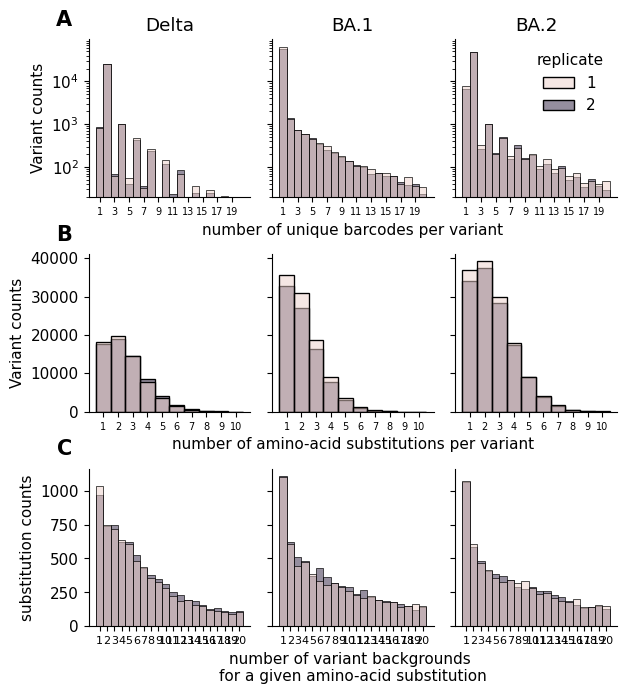

In [94]:
# Take away Panel A
# add median to each
# range of genotype backgrounds out to 50

saveas = f"raw_data_summary_barcodes_backgrounds_hist"
logscale=False
fig, ax = plt.subplots(3,3, sharex="row", sharey="row", figsize=[6.4, 7])

condition_title = {
    "Delta":"Delta",
    "Omicron_BA1" : "BA.1",
    "Omicron_BA2" : "BA.2"
}

row = 0
for col, (condition, condition_df) in enumerate(func_score_df.groupby("condition")):
    n = len(condition_df)
    iter_ax = ax[row, col]
    vc = condition_df.value_counts(["aa_substitutions", "replicate"]).reset_index()
    wt_vc = vc.query("aa_substitutions == ''")
    non_wt_vc = vc.query("aa_substitutions != ''")
    sns.histplot(non_wt_vc.query("count <= 20"), x="count", ax=iter_ax, hue="replicate", discrete=True)
    iter_ax.set_yscale('log')
    iter_ax.set_xticks(
            [i+1 for i in range(20) if i%2 == 0],
            labels=[i+1 for i in range(20) if i%2 == 0], 
            ha="center",
            size=7
    )
    if col != 2: 
        iter_ax.get_legend().remove()
    else:
        iter_ax.get_legend()
        
    xlabel = "number of unique barcodes per variant" if col == 1 else ""
    ylabel = "Variant counts" if col == 0 else ""
    iter_ax.set_ylabel(ylabel)
    iter_ax.set_xlabel(xlabel)
    iter_ax.set_title(condition_title[condition])
    sns.despine(ax=iter_ax)

row = 1
for col, (condition, condition_df) in enumerate(func_score_df.groupby("condition")):
    iter_ax = ax[row, col]
    
    df = condition_df.query("aa_substitutions != ''")
    df = df.assign(
        num_muts = [
            len(aa_subs.split())
            for aa_subs in df.aa_substitutions
        ]
    )
    
    sns.histplot(df.query("num_muts <= 10"), x="num_muts", ax=iter_ax, hue="replicate", discrete=True)
    if logscale: iter_ax.set_yscale('log')
    iter_ax.get_legend().remove()
    xscale = "number of amino-acid substitutions per variant" if col == 1 else ""
    iter_ax.set_xlabel(xscale)
    
    ylabel = "Variant counts" if col == 0 else ""
    iter_ax.set_ylabel(ylabel)
    iter_ax.set_xticks(
        [i+1 for i in range(10)],
        labels=[i+1 for i in range(10)], 
        ha="center",
        size=7
    )
    sns.despine(ax=iter_ax)

row = 2
collapsed_bc_df = func_score_df.groupby(
    ["replicate", "condition", "aa_substitutions"]
).aggregate("mean").reset_index()
for col, (condition, condition_df) in enumerate(collapsed_bc_df.groupby("condition")):
    iter_ax = ax[row, col]
    df = pd.DataFrame()
    for rep, rep_df in condition_df.groupby("replicate"):
        
        times_seen = (
            rep_df["aa_substitutions"].str.split().explode().value_counts()
        )
        if (times_seen == times_seen.astype(int)).all():
            times_seen = times_seen.astype(int)
        times_seen = pd.DataFrame(times_seen)
        times_seen.index.name = f"mutation"
        df = pd.concat([df, times_seen.assign(replicate=rep).reset_index()])

    sns.histplot(df.query("count <= 20"), x="count", ax=iter_ax,  hue="replicate", discrete=True)
    for rep, rep_df in df.groupby("replicate"):
        print(f"{condition} {rep} median backgounds {rep_df['count'].median()}")
        
    iter_ax.get_legend().remove()
    xscale = "number of variant backgrounds \nfor a given amino-acid substitution" if col == 1 else ""
    iter_ax.set_xlabel(xscale)
    ylabel = f"substitution counts" if col == 0 else ""
    iter_ax.set_ylabel(ylabel)
    iter_ax.set_xticks(
        [i+1 for i in range(20)],
        labels=[i+1 for i in range(20) ], 
        ha="center",
        size=8
    )
    sns.despine(ax=iter_ax)

plt.tight_layout()

ax[0,0].text(
    -0.1, 1.06, 
    f"A", 
    ha="right", va="bottom", 
    size=15,
    weight="bold",
    transform=ax[0,0].transAxes
)
ax[1,0].text(
    -0.1, 1.06, 
    f"B", 
    ha="right", va="bottom", 
    size=15,
    weight="bold",
    transform=ax[1,0].transAxes
)
ax[2,0].text(
    -0.1, 1.06, 
    f"C", 
    ha="right", va="bottom", 
    size=15,
    weight="bold",
    transform=ax[2,0].transAxes
)

fig.savefig(f"{OUTDIR}/{saveas}.pdf")
fig.savefig(f"{OUTDIR}/{saveas}.png")
plt.show()

## Correlation of Replicate Functional Scores

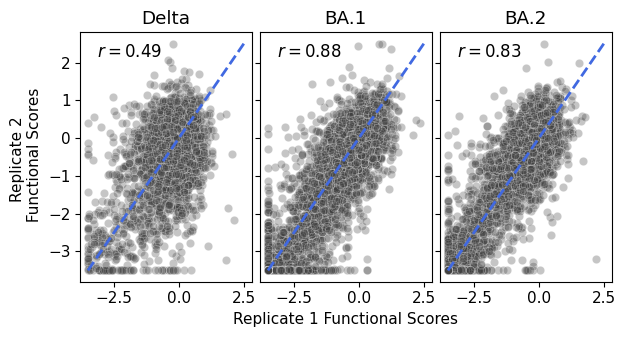

In [95]:
# Capitalization
# add distributions
# square up the scatters and match ticks

saveas = "replicate_functional_score_correlation_scatter"

fig, ax = plt.subplots(1,3, sharex="row", sharey="row", figsize=[6.4, 3.5])
collapsed_bc_df = func_score_df.groupby(
    ["replicate", "condition", "aa_substitutions"]
).aggregate("mean").reset_index()
for col, (condition, condition_df) in enumerate(collapsed_bc_df.groupby("condition")):
    iter_ax = ax[col]
    df = reduce(
        lambda left, right: pd.merge(
            left, right, left_index=True, right_index=True, how="inner"
        ),
        [
            rep_df.rename({"func_score":f"rep_{rep}_func_score"}, axis=1).set_index("aa_substitutions")
            for rep, rep_df in condition_df.groupby("replicate") 
        ],
    )
    sns.scatterplot(
        df, 
        x="rep_1_func_score", 
        y="rep_2_func_score", 
        ax =iter_ax,
        alpha=0.3,
        c='0.25'
    )
    iter_ax.plot([-3.5, 2.5], [-3.5, 2.5], "--", lw=2, c="royalblue")
    corr = pearsonr(df["rep_1_func_score"], df["rep_2_func_score"])[0]
    iter_ax.annotate(
        f"$r = {corr:.2f}$", 
        (0.1, 0.9), 
        xycoords="axes fraction", 
        fontsize=12
    )
    iter_ax.set_title(condition)


ax[0].set_xlabel("")
ax[0].set_ylabel("Replicate 2 \n Functional Scores")

ax[1].set_xlabel("Replicate 1 Functional Scores")
ax[1].set_title("BA.1")
ax[2].set_xlabel("")
ax[2].set_title("BA.2")

# fig.suptitle("Variant Functional Score \nReplicate Correlation")
plt.tight_layout()
fig.subplots_adjust(wspace=0.05)
fig.savefig(f"{OUTDIR}/{saveas}.pdf")
fig.savefig(f"{OUTDIR}/{saveas}.png")
plt.show()

## Convergence Analysis

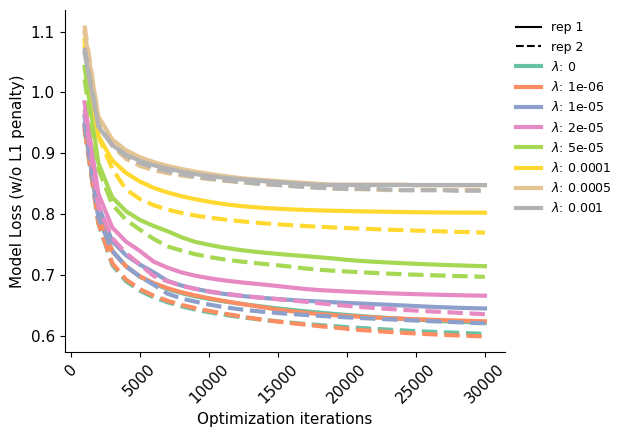

In [96]:
saveas="convergence_all_lasso_lines"
cmap=plt.get_cmap("Set2")


fig, ax = plt.subplots(1,figsize=[6.4,4.5])
color_idx = -1
for i, (model, model_row) in enumerate(models.iterrows()):
    if i%2 == 0: color_idx += 1

    ax.plot(
        [1000 * (s+1) for s in range(len(model_row.step_loss))],
        model_row.step_loss,
        c=cmap.colors[color_idx],
        lw=3,
        linestyle="-" if model_row.replicate == 0 else "--",
        label=f"rep: {model_row.replicate} λ: {model_row.λ_lasso_shift}"
    )
ax.set_xticks(ax.get_xticks()[1:-1], ax.get_xticklabels()[1:-1], rotation=45, ha='center')
ax.set_ylabel("Model Loss (w/o L1 penalty)")
ax.set_xlabel("Optimization iterations")

black_line = mlines.Line2D([], [], color='black', linestyle='-',
                          markersize=5, label='rep 1')
black_dashed = mlines.Line2D([], [], color='black',linestyle='--',
                          markersize=5, label='rep 2')
lasso_color_handles = [
    mlines.Line2D(
        [], [], 
        color=color, 
        linestyle='-',
        markersize=5,
        linewidth=3,
        label="$\lambda$: "+str(lasso)
    )
    for lasso, color in zip(models.λ_lasso_shift.unique(), cmap.colors)
]

elements = [black_line, black_dashed] + lasso_color_handles
ax.legend(handles=elements, bbox_to_anchor = (1, 1), loc='upper left', frameon=False, fontsize=9)
sns.despine(ax=ax)

# fig.suptitle("Replicate Fit Convergence")
plt.tight_layout()
fig.savefig(f"{OUTDIR}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{OUTDIR}/{saveas}.png",bbox_inches='tight')
plt.show()

## Shrinkage Analysis

In [98]:
tall_mut_df = pd.DataFrame()
for replicate, rep_models in models.groupby("replicate"):
    fit_dict = {f"l_{float(row.λ_lasso_shift)}":row[model_name] for _, row in rep_models.iterrows()}
    
    
    mut_df = multidms.utils.combine_replicate_muts(
        fit_dict, 
        times_seen_threshold=times_seen_threshold, 
        how="outer"
    )


    mut_df = pd.melt(
        mut_df.reset_index(), 
        id_vars=["mutation"],
        value_vars=[
            col for col in mut_df.columns 
            if "_S_" in col and "avg" not in col
        ],
        value_name="S"
    )
    mut_df = mut_df.assign(
        λ_lasso=[ 
            v.split("_")[1]
            for v in mut_df.variable
        ],
        sense=[
            "Nonsense" if "*" in mut else "Missense"
            for mut in mut_df.mutation
        ],
        condition=[
            "_".join(v.split("_")[3:])
            for v in mut_df.variable
        ],
        replicate=replicate
    )
    
    mut_df.drop("variable", axis=1, inplace=True)
    tall_mut_df = pd.concat([tall_mut_df, mut_df])
    
tall_mut_df

,mutation,S,λ_lasso,sense,condition,replicate
0,M1I,0.365254,0.0,Missense,Delta,0
1,F2I,-0.551856,0.0,Missense,Delta,0
2,F2L,-0.133367,0.0,Missense,Delta,0
3,F2S,0.186726,0.0,Missense,Delta,0
4,F2V,-1.471370,0.0,Missense,Delta,0
...,...,...,...,...,...,...
103611,S1252T,-0.000000,0.001,Missense,Omicron_BA2,1
103612,S1252V,-0.000000,0.001,Missense,Omicron_BA2,1
103613,S1252W,-0.000000,0.001,Missense,Omicron_BA2,1
103614,S1252Y,-0.000000,0.001,Missense,Omicron_BA2,1


In [99]:
def loss(model, condition):
    kwargs = {
        'λ_ridge_beta': 0.,
        'λ_ridge_shift': 0.,
        'λ_ridge_gamma': 0.
    }
    
    data = (
        {condition:model.data.training_data["X"][condition]}, 
        {condition:model.data.training_data["y"][condition]}
    )
    
    params = model.get_condition_params(condition)
    return jax.jit(model._model_components["objective"])(model.params, data)

lasso_sparsity_loss = defaultdict(list)
for lasso, lasso_replicates in models.groupby("λ_lasso_shift"):
    lasso_sparsity_loss["lasso"].append(str(lasso))
    fit_dict = {}
    for _, row in lasso_replicates.iterrows():
        model = row[model_name]
        replicate = row.replicate
        fit_dict[f"{replicate}"] = model

    muts_df_outer = multidms.utils.combine_replicate_muts(
        fit_dict, 
        times_seen_threshold=times_seen_threshold, 
        how="outer"
    )
    muts_df_outer = muts_df_outer.assign(
        sense = [
            "Nonsense" if "*" in mut else "Missense"
            for mut in muts_df_outer.index.values
        ]
    )

    muts_df_inner = muts_df_outer.dropna()
    
    # plot corr by sparsity
    for cond in model.data.conditions:
        if cond == model.data.reference: continue
        if np.all(muts_df_inner[f"0_S_{cond}"] <= 0.05) or np.all(muts_df_inner[f"1_S_{cond}"] <= 0.05):
            lasso_sparsity_loss[f"{cond}-replicate-correlation"].append(np.nan)
            lasso_sparsity_loss[f"{cond}-replicate-correlation-interval"].append(np.nan)
        else:
            corr = pearsonr(muts_df_inner[f"0_S_{cond}"], muts_df_inner[f"1_S_{cond}"])
            r = corr[0]
            interval = corr.confidence_interval()
            lasso_sparsity_loss[f"{cond}-replicate-correlation"].append(r)
            lasso_sparsity_loss[f"{cond}-replicate-correlation-interval"].append(
                tuple[(interval.low, interval.high)]
            )
        
        for rep, marker in zip([0,1], ["o", "D"]):
            rep_cond_shifts = muts_df_outer[[f"{rep}_S_{cond}", "sense"]].dropna()
            for sense, color in zip(["Nonsense", "Missense"], ["red", "blue"]):
                shifts = rep_cond_shifts.query("sense == @sense")[f"{rep}_S_{cond}"]
                sparsity = len(shifts[shifts==0]) / len(shifts)
                lasso_sparsity_loss[f"{cond}-{rep}-{sense}-sparsity"].append(sparsity)
            
    # plot loss 
    for _, row in lasso_replicates.iterrows():
        model = row[model_name]
        rep = row.replicate
        for cond in model.data.conditions:
            if cond == model.data.reference: continue
            lasso_sparsity_loss[f"{cond}-{rep}-loss"].append(loss(model, cond))

lasso_sparsity_loss = pd.DataFrame(lasso_sparsity_loss)
lasso_sparsity_loss

,lasso,Delta-replicate-correlation,Delta-replicate-correlation-interval,Delta-0-Nonsense-sparsity,Delta-0-Missense-sparsity,Delta-1-Nonsense-sparsity,Delta-1-Missense-sparsity,Omicron_BA2-replicate-correlation,Omicron_BA2-replicate-correlation-interval,Omicron_BA2-0-Nonsense-sparsity,Omicron_BA2-0-Missense-sparsity,Omicron_BA2-1-Nonsense-sparsity,Omicron_BA2-1-Missense-sparsity,Delta-0-loss,Omicron_BA2-0-loss,Delta-1-loss,Omicron_BA2-1-loss
0,0.0,0.550706,"tuple[0.5327558001438703, 0.568161329620449]",0.000000,0.000000,0.000000,0.000000,0.626114,"tuple[0.6104194327667188, 0.641317137901075]",0.000000,0.000000,0.000000,0.000000,0.2087812698808719,0.18673930061615424,0.24558407543928598,0.17621512274569837
1,1e-06,0.569073,"tuple[0.5516440307110266, 0.5860048816396765]",0.010582,0.011265,0.018868,0.015645,0.614877,"tuple[0.598827218641175, 0.6304333205571957]",0.031746,0.021403,0.042453,0.025223,0.20968838484828134,0.1875596507683098,0.24536241772804607,0.1761502312391511
2,1e-05,0.643579,"tuple[0.6284502611894246, 0.6582214322982628]",0.423280,0.145961,0.344340,0.145594,0.625655,"tuple[0.6099453114071763, 0.6408722337022443]",0.539683,0.224976,0.533019,0.207056,0.21728593425845505,0.1946640510742787,0.2570902114259448,0.18425789002783124
3,2e-05,0.665407,"tuple[0.6510077922406747, 0.6793274202163707]",0.777778,0.250241,0.641509,0.257822,0.681500,"tuple[0.6676554046628856, 0.6948737938541736]",0.867725,0.391696,0.896226,0.360153,0.22450889632568466,0.20096912521039875,0.26543152623553207,0.18841946812710644
4,5e-05,0.699546,"tuple[0.6863391633486625, 0.7122913765582897]",0.978836,0.483907,0.962264,0.493295,0.744132,"tuple[0.7325769740124719, 0.7552587141753088]",0.994709,0.644030,0.995283,0.616220,0.24224307111134985,0.21271545188582364,0.28434654136265564,0.19949324054447795
5,0.0001,0.676946,"tuple[0.6629427653242231, 0.6904754754536244]",1.000000,0.906984,1.000000,0.829342,0.755060,"tuple[0.7439262761110392, 0.7657755470376886]",1.000000,0.932893,1.000000,0.876756,0.2761963692839127,0.23071412313239983,0.3111371143886215,0.2155335190605666
6,0.0005,NaN,NaN,1.000000,1.000000,1.000000,0.999840,NaN,NaN,1.000000,0.999839,1.000000,0.999840,0.2955295555366075,0.24429836439257377,0.3358935518271298,0.23729005809168738
7,0.001,NaN,NaN,1.000000,1.000000,1.000000,1.000000,NaN,NaN,1.000000,1.000000,1.000000,1.000000,0.29580652304326244,0.2443851190766541,0.33547136586106335,0.23737351025200742


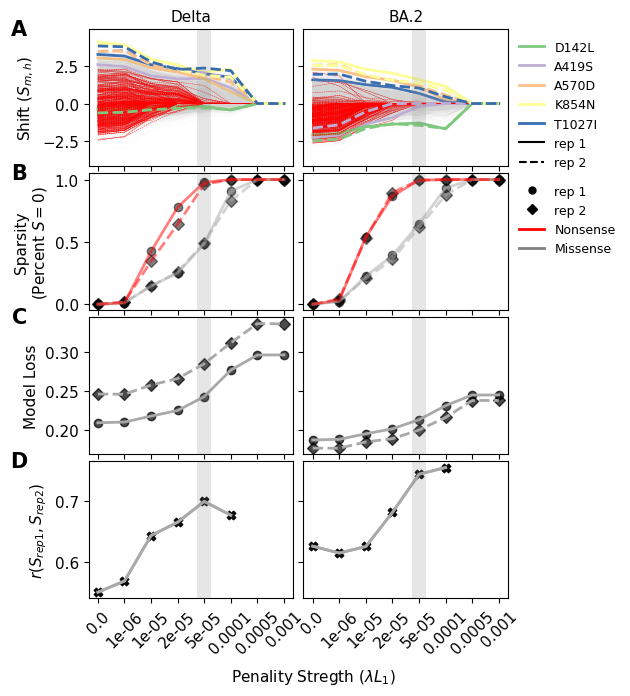

In [100]:
# Change missense - > Non synonymous
# call percent - > "fraction"
# Change lambda to whatever we decide for the lexicon

saveas="shrinkage_analysis_trace_plots"
fig, ax = plt.subplots(4,2, figsize=[6.4,7],sharex=True, sharey='row')

lasso_cmap=plt.get_cmap("Set2").colors
lasso_shrinkage = sorted(models.λ_lasso_shift.unique())
lasso_shrinkage_cmap = dict(zip(lasso_shrinkage, lasso_cmap))

mutations_to_highlight = ["D142L", "A419S", "A570D", "K854N", "T1027I"]
mutations_cmap=plt.get_cmap("Accent").colors
mutations_cmap = dict(zip(mutations_to_highlight, mutations_cmap))

condition_col = {
    "Delta" : 0,
    "Omicron_BA2" : 1
}

replicate_line_style = {
    0 : "-",
    1 : "--"
}

replicate_marker = {
    0 : "o",
    1 : "D"
}

sense_colors = {
    "Missense" : "darkgrey",
    "Nonsense" : "red"
}

sense_lw = {
    "Missense" : 0.5,
    "Nonsense" : 0.3
}

sense_alpha = {
    "Missense" : 0.1,
    "Nonsense" : 1.0
}

model_choice = 5e-5
model_line_kwargs = {
    "linewidth" : 10,
    "color" : "grey",
    "alpha" : 0.1
}

for (condition, replicate), df in tall_mut_df.groupby(["condition", "replicate"]):
    row = 0
    iter_ax = ax[row, condition_col[condition]]
    
    # plot missense, non validated
    for mut, trace_df in df.query(
        "sense == 'Missense' & not mutation.isin(@mutations_to_highlight)"
    ).groupby("mutation"):
        iter_ax.plot(
            trace_df.λ_lasso, 
            trace_df.S,
            linestyle=replicate_line_style[replicate],
            linewidth=sense_alpha['Missense'],
            alpha=sense_alpha['Missense'],
            color="lightgrey"
        )
    
    # plot stop traces
    for mut, trace_df in df.query("sense == 'Nonsense'").groupby("mutation"):

        iter_ax.plot(
            trace_df.λ_lasso, 
            trace_df.S,
            linestyle=replicate_line_style[replicate],
            linewidth=sense_lw['Nonsense'],
            alpha=sense_alpha['Nonsense'],
            color=sense_colors['Nonsense']
        )

    # plot highlighted muts
    for mut, trace_df in df.query(
        "mutation.isin(@mutations_to_highlight)"
    ).groupby("mutation"):
        iter_ax.plot(
            trace_df.λ_lasso, 
            trace_df.S,
            linestyle=replicate_line_style[replicate],
            linewidth=2,
            alpha=1.0,
            color=mutations_cmap[mut]
        )
    iter_ax.axvline(str(model_choice), **model_line_kwargs)
    
        
    # Plot sparsity    
    row = 1
    iter_ax = ax[row, condition_col[condition]]
    for sense in ["Missense", "Nonsense"]:
        iter_ax.plot(
            lasso_sparsity_loss["lasso"],
            lasso_sparsity_loss[f"{condition}-{replicate}-{sense}-sparsity"],
            linestyle=replicate_line_style[replicate],
            linewidth=2,
            alpha=0.5,
            color=sense_colors[sense]
        )
        
        iter_ax.scatter(
            lasso_sparsity_loss["lasso"],
            lasso_sparsity_loss[f"{condition}-{replicate}-{sense}-sparsity"],
            marker=replicate_marker[replicate],
            alpha=0.5,
            color="black"
        )
    iter_ax.axvline(str(model_choice), **model_line_kwargs)
        
    # Plot Loss  
    row = 2
    iter_ax = ax[row, condition_col[condition]]
    
    iter_ax.plot(
        lasso_sparsity_loss["lasso"],
        lasso_sparsity_loss[f"{condition}-{replicate}-loss"],
        linestyle=replicate_line_style[replicate],
        linewidth=2,
        alpha=1.0,
        color="darkgrey"
    )

    iter_ax.scatter(
        lasso_sparsity_loss["lasso"],
        lasso_sparsity_loss[f"{condition}-{replicate}-loss"],
        marker=replicate_marker[replicate],
        alpha=0.7,
        color="black"
    )
    iter_ax.axvline(str(model_choice), **model_line_kwargs)
    
    # Plot Correlation  
    row = 3
    iter_ax = ax[row, condition_col[condition]]
    
    iter_ax.plot(
        lasso_sparsity_loss["lasso"],
        lasso_sparsity_loss[f"{condition}-replicate-correlation"],
        linestyle="-",
        linewidth=2,
        alpha=1.0,
        color="darkgrey"
    )
    
    iter_ax.scatter(
        lasso_sparsity_loss["lasso"],
        lasso_sparsity_loss[f"{condition}-replicate-correlation"],
        marker="X",
        alpha=0.7,
        color="black"
    )
    iter_ax.axvline(str(model_choice), **model_line_kwargs)

ax[0, 0].set_title("Delta", size=11)
ax[0, 1].set_title("BA.2", size=11)

ax[0, 0].set_ylabel("Shift $(S_{m,h})$", size=11)
ax[1, 0].set_ylabel("Sparsity\n(Percent $S = 0$)", size=11)
ax[2, 0].set_ylabel("Model Loss", size=11)
ax[3, 0].set_ylabel("$r(S_{rep1},S_{rep2})$", size=11)


# TODO legends
black_line = mlines.Line2D([], [], color='black', linestyle='-',
                          markersize=5, label='rep 1')
black_dashed = mlines.Line2D([], [], color='black',linestyle='--',
                          markersize=5, label='rep 2')
lasso_color_handles = [
    mlines.Line2D(
        [], [], 
        color=color, 
        linestyle='-',
        markersize=2,
        linewidth=2,
        label=mut
    )
    for mut, color in mutations_cmap.items()
]

elements = lasso_color_handles + [black_line, black_dashed] 
ax[0,1].legend(handles=elements, bbox_to_anchor = (1, 1), loc='upper left', frameon=False, fontsize=9)

black_circle = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                          markersize=5, label='rep 1')
black_triangle = mlines.Line2D([], [], color='black', marker='D', linestyle='None',
                          markersize=5, label='rep 2')

red_line = mlines.Line2D([], [], color='red', linewidth=2,linestyle='-',markersize=5, label='Nonsense')
grey_line = mlines.Line2D([], [], color='grey',linewidth=2, linestyle='-',markersize=5, label='Missense')

elements = [black_circle, black_triangle, red_line, grey_line] #+lasso_color_handles
ax[1, 1].legend(handles=elements, bbox_to_anchor = (1, 1), loc='upper left', frameon=False, fontsize=9)

ax[3,0].set_xticks(ax[3,0].get_xticks(), ax[3,0].get_xticklabels(), rotation=45, ha='center')
ax[3,1].set_xticks(ax[3,1].get_xticks(), ax[3,1].get_xticklabels(), rotation=45, ha='center')

ax[3,0].set_xlabel(f"Penality Stregth ($\lambda L_{1}$)")
ax[3,0].xaxis.set_label_coords(1.1, -.5)

plt.tight_layout()




fig.subplots_adjust(hspace=0.05, wspace=0.05)


ax[0,0].text(
    -0.3, 1.00, 
    f"A", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=ax[0,0].transAxes
)
ax[1,0].text(
    -0.3, 1.00, 
    f"B", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=ax[1,0].transAxes
)
ax[2,0].text(
    -0.3, 1.00, 
    f"C", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=ax[2,0].transAxes
)
ax[3,0].text(
    -0.3, 1.00, 
    f"D", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=ax[3,0].transAxes
)


fig.savefig(f"{OUTDIR}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{OUTDIR}/{saveas}.png",bbox_inches='tight')
plt.show()

## Global Epistasis Fits

In [101]:
chosen_replicate_models = models.query("λ_lasso_shift == 5e-5")
replicate_data = {}
for row_idx, replicate_row in chosen_replicate_models.iterrows():    
     
    model = replicate_row[model_name]
    df = model.variants_df
    xlb, xub = [-1, 1] + np.quantile(df.predicted_latent, [0.05, 1.0])
    ylb, yub = [-1, 1] + np.quantile(df.corrected_func_score, [0.05, 1.0])
    additive_model_grid = np.linspace(xlb, xub, num=1000)
    params = model.get_condition_params(model.data.reference)
    latent_preds = model._model_components["g"](params["α"], additive_model_grid)
    shape = (additive_model_grid, latent_preds)   
    
    replicate_data[replicate_row.replicate] = {
        "variants_df" : df,
        "wildtype_df" : model.wildtype_df,
        "epistasis_shape" : shape,
        "condition_colors" : model.data.condition_colors
    }

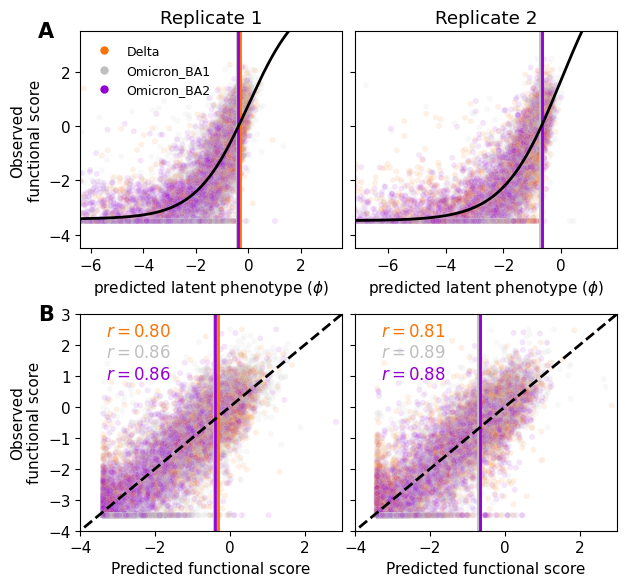

In [102]:
saveas="global_epistasis_and_prediction_correlations"
fig, ax = plt.subplots(2,2, figsize=[6.4,6], sharey='row')    

row=0
for replicate, data in replicate_data.items():

    iter_ax = ax[row, replicate]
    sns.scatterplot(
        data=data["variants_df"].sample(frac=0.1),
        x="predicted_latent",
        y=f"corrected_func_score",
        hue="condition",
        palette=model.data.condition_colors,
        ax=iter_ax,
        legend=False,
        size=5,
        alpha=0.1,
        lw=3
    )
    
    for condition, values in data["wildtype_df"].iterrows():
        iter_ax.axvline(
            values.predicted_latent,
            label=condition,
            c=model.data.condition_colors[condition],
            lw=2,
        )
    
    iter_ax.plot(*data["epistasis_shape"], color="k", lw=2)
    
    xlb, xub = [-1, 1] + np.quantile(data["variants_df"].predicted_latent, [0.05, 1.0])
    ylb, yub = [-1, 1] + np.quantile(data["variants_df"].corrected_func_score, [0.05, 1.0])
    iter_ax.set_xlim([xlb, xub])
    iter_ax.set_ylim([ylb, yub])
    iter_ax.set_title(f"Replicate {replicate+1}")
    iter_ax.set_ylabel("Observed\nfunctional score")
    iter_ax.set_xlabel("predicted latent phenotype ($\phi$)")

row=1
for replicate, data in replicate_data.items():

    iter_ax = ax[row, replicate]
    sns.scatterplot(
        data=data["variants_df"].sample(frac=0.1),
        x="predicted_func_score",
        y=f"corrected_func_score",
        hue="condition",
        palette=model.data.condition_colors,
        ax=iter_ax,
        legend=False,
        size=5,
        alpha=0.1
    )
    
    for condition, values in data["wildtype_df"].iterrows():
        iter_ax.axvline(
            values.predicted_latent,
            label=condition,
            c=model.data.condition_colors[condition],
            lw=2,
        )
    
    xlb, xub = [-1, 1] + np.quantile(data["variants_df"].predicted_latent, [0.05, 1.0])
    ylb, yub = [-1, 1] + np.quantile(data["variants_df"].corrected_func_score, [0.05, 1.0])
    
    iter_ax.plot([ylb, yub], [ylb, yub], "k--", lw=2)
    iter_ax.set_xlim([-4, 3])
    iter_ax.set_ylim([-4, 3])
    iter_ax.set_ylabel("Observed\nfunctional score")
    iter_ax.set_xlabel("Predicted functional score")

    start_y = 0.9
    for c, cdf in data["variants_df"].groupby("condition"):
        r = pearsonr(
            cdf["predicted_func_score"],
            cdf["corrected_func_score"]
        )[0]
        iter_ax.annotate(
            f"$r = {r:.2f}$",
            (0.1, start_y),
            xycoords="axes fraction",
            fontsize=12,
            c=model.data.condition_colors[c],
        )
        start_y += -0.1


elements = [
    mlines.Line2D([], [], color=color, marker='o', linestyle='None',markersize=5, label=condition)
    for condition, color in replicate_data[0]["condition_colors"].items()
]


ax[0, 0].legend(
    handles=elements, 
    bbox_to_anchor = (0., .99), 
    loc='upper left', 
    frameon=False, 
    fontsize=9
)
    
    
plt.tight_layout()
fig.subplots_adjust(wspace=0.05)

ax[0,0].text(
    -0.1, 1.00, 
    f"A", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=ax[0,0].transAxes
)
ax[1,0].text(
    -0.1, 1.00, 
    f"B", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=ax[1,0].transAxes
)


fig.savefig(f"{OUTDIR}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{OUTDIR}/{saveas}.png",bbox_inches='tight')
plt.show()


In [103]:
model.params

{'C_Delta': Array([1.2595955], dtype=float64),
 'C_Omicron_BA1': Array([0.], dtype=float64),
 'C_Omicron_BA2': Array([-1.62703849], dtype=float64),
 'C_ref': Array([-0.72743002], dtype=float64),
 'S_Delta': Array([ 0.        ,  0.        ,  0.        , ..., -0.22930755,
         0.05374312,  0.        ], dtype=float64),
 'S_Omicron_BA1': Array([0., 0., 0., ..., 0., 0., 0.], dtype=float64),
 'S_Omicron_BA2': Array([ 0.        ,  0.        ,  0.        , ..., -0.18083705,
        -0.0725221 ,  0.        ], dtype=float64),
 'α': {'ge_bias': Array([-3.48738871], dtype=float64),
  'ge_scale': Array([10.37785037], dtype=float64)},
 'β': Array([-3.50368799e-01, -3.92795829e+00, -1.69368532e+00, ...,
         4.60168345e-01,  1.87514240e-03, -1.97124647e-01], dtype=float64),
 'γ_Delta': Array([0.], dtype=float64),
 'γ_Omicron_BA1': Array([0.], dtype=float64),
 'γ_Omicron_BA2': Array([0.], dtype=float64)}

## Combined Trace and epistasis

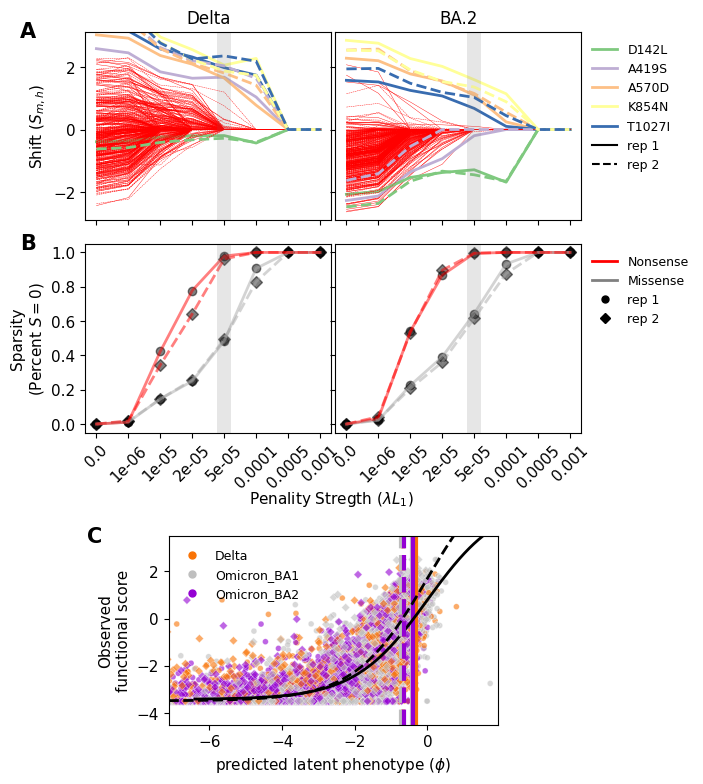

In [104]:
saveas="shrinkage_analysis_trace_plots_with_epistasis"
# fig, ax = plt.subplots(4,2, figsize=[6.4,7],sharex=True, sharey='row')

fig = plt.figure(figsize=[6.4, 9])
row1 = ["Delta_trace"]*3 + ["Omicron_BA2_trace"]*3
row2 = ["Delta_sparse"]*3 + ["Omicron_BA2_sparse"]*3
row3 = ["."]+["epistasis"]*4 + ["."]

axs = fig.subplot_mosaic(
    [
        row1,
        row2,
        ["."] * 6,
        row3
    ],
    height_ratios=[1,1,0.3,1],
#     width_ratios=width_ratios,
    empty_sentinel=".",
    gridspec_kw={
        "wspace": 0.05,
        "hspace": 0.15,
    }
)

lasso_cmap=plt.get_cmap("Set2").colors
lasso_shrinkage = sorted(models.λ_lasso_shift.unique())
lasso_shrinkage_cmap = dict(zip(lasso_shrinkage, lasso_cmap))

mutations_to_highlight = ["D142L", "A419S", "A570D", "K854N", "T1027I"]
mutations_cmap=plt.get_cmap("Accent").colors
mutations_cmap = dict(zip(mutations_to_highlight, mutations_cmap))

# condition_col = {
#     "Delta" : 0,
#     "Omicron_BA2" : 1
# }

replicate_line_style = {
    0 : "-",
    1 : "--"
}

replicate_marker = {
    0 : "o",
    1 : "D"
}

sense_colors = {
    "Missense" : "darkgrey",
    "Nonsense" : "red"
}

sense_lw = {
    "Missense" : 0.5,
    "Nonsense" : 0.3
}

sense_alpha = {
    "Missense" : 0.1,
    "Nonsense" : 1.0
}

model_choice = 5e-5
model_line_kwargs = {
    "linewidth" : 10,
    "color" : "grey",
    "alpha" : 0.1
}

for (condition, replicate), df in tall_mut_df.groupby(["condition", "replicate"]):
#     row = 0
    iter_ax = axs[f"{condition}_trace"]
    
    # plot missense, non validated
#     for mut, trace_df in df.query(
#         "sense == 'Missense' & not mutation.isin(@mutations_to_highlight)"
#     ).groupby("mutation"):
#         iter_ax.plot(
#             trace_df.λ_lasso, 
#             trace_df.S,
#             linestyle=replicate_line_style[replicate],
#             linewidth=sense_alpha['Missense'],
#             alpha=sense_alpha['Missense'],
#             color="lightgrey"
#         )
    
    # plot stop traces
    for mut, trace_df in df.query("sense == 'Nonsense'").groupby("mutation"):

        iter_ax.plot(
            trace_df.λ_lasso, 
            trace_df.S,
            linestyle=replicate_line_style[replicate],
            linewidth=sense_lw['Nonsense'],
            alpha=sense_alpha['Nonsense'],
            color=sense_colors['Nonsense']
        )

    # plot highlighted muts
    for mut, trace_df in df.query(
        "mutation.isin(@mutations_to_highlight)"
    ).groupby("mutation"):
        iter_ax.plot(
            trace_df.λ_lasso, 
            trace_df.S,
            linestyle=replicate_line_style[replicate],
            linewidth=2,
            alpha=1.0,
            color=mutations_cmap[mut]
        )
    iter_ax.axvline(str(model_choice), **model_line_kwargs)
#     iter_ax.tick_params()
    iter_ax.tick_params(axis='x', bottom=True, labelbottom=False)
    if condition == "Omicron_BA2": iter_ax.tick_params(axis='y', left=True, labelleft=False)
    
    
        
    # Plot sparsity    
#     row = 1
    iter_ax = axs[f"{condition}_sparse"]
#     iter_ax = ax[row, condition_col[condition]]
    for sense in ["Missense", "Nonsense"]:
        iter_ax.plot(
            lasso_sparsity_loss["lasso"],
            lasso_sparsity_loss[f"{condition}-{replicate}-{sense}-sparsity"],
            linestyle=replicate_line_style[replicate],
            linewidth=2,
            alpha=0.5,
            color=sense_colors[sense]
        )
        
        iter_ax.scatter(
            lasso_sparsity_loss["lasso"],
            lasso_sparsity_loss[f"{condition}-{replicate}-{sense}-sparsity"],
            marker=replicate_marker[replicate],
            alpha=0.5,
            color="black"
        )
    iter_ax.axvline(str(model_choice), **model_line_kwargs)
    iter_ax.set_xticks(iter_ax.get_xticks(), iter_ax.get_xticklabels(), rotation=45, ha='center')
    if condition == "Omicron_BA2": iter_ax.tick_params(axis='y', left=True, labelleft=False)
    
#     ax[3,1].set_xticks(iter_ax.get_xticks(), iter_ax.get_xticklabels(), rotation=45, ha='center')

for r1, r2 in zip(row1, row2):
    axs[r2].sharex(axs[r1])
    
axs["Delta_trace"].sharey(axs["Omicron_BA2_trace"])
axs["Delta_sparse"].sharey(axs["Omicron_BA2_sparse"])
axs["Delta_trace"].set_ylabel("Shift $(S_{m,h})$", size=11)
axs["Delta_sparse"].set_ylabel("Sparsity\n(Percent $S = 0$)", size=11)
# axs["Delta_sparse"].set_xlabel("Sparsity\n(Percent $S = 0$)", size=11)
axs["Delta_sparse"].set_xlabel(f"Penality Stregth ($\lambda L_{1}$)")
axs["Delta_sparse"].xaxis.set_label_coords(1.0, -.3)
axs["Delta_trace"].set_title("Delta", size=12)
axs["Omicron_BA2_trace"].set_title("BA.2", size=12)

# TODO legends
black_line = mlines.Line2D([], [], color='black', linestyle='-',
                          markersize=5, label='rep 1')
black_dashed = mlines.Line2D([], [], color='black',linestyle='--',
                          markersize=5, label='rep 2')
lasso_color_handles = [
    mlines.Line2D(
        [], [], 
        color=color, 
        linestyle='-',
        markersize=2,
        linewidth=2,
        label=mut
    )
    for mut, color in mutations_cmap.items()
]

elements = lasso_color_handles + [black_line, black_dashed] 
axs["Omicron_BA2_trace"].legend(handles=elements, 
                                bbox_to_anchor = (1, 1), loc='upper left', frameon=False, fontsize=9)

black_circle = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                          markersize=5, label='rep 1')
black_triangle = mlines.Line2D([], [], color='black', marker='D', linestyle='None',
                          markersize=5, label='rep 2')

red_line = mlines.Line2D([], [], color='red', linewidth=2,linestyle='-',markersize=5, label='Nonsense')
grey_line = mlines.Line2D([], [], color='grey',linewidth=2, linestyle='-',markersize=5, label='Missense')

elements = [red_line, grey_line, black_circle, black_triangle] #+lasso_color_handles
axs["Omicron_BA2_sparse"].legend(handles=elements, bbox_to_anchor = (1, 1), loc='upper left', frameon=False, fontsize=9)

# row=0
for replicate, data in replicate_data.items():

    iter_ax = axs["epistasis"]
    sns.scatterplot(
        data=data["variants_df"].sample(frac=0.05),
        x="predicted_latent",
        y=f"corrected_func_score",
        hue="condition",
        palette=model.data.condition_colors,
        ax=iter_ax,
        legend=False,
        size=5,
        alpha=0.6,
        marker=replicate_marker[replicate]
#         lw=3
    )
    
    # WT LINES
    for condition, values in data["wildtype_df"].iterrows():
        iter_ax.axvline(
            values.predicted_latent,
            label=condition,
            c=model.data.condition_colors[condition],
            lw=3,
            linestyle=replicate_line_style[replicate],
            
        )
    
    # SHAPE OF EPISTASIS
    iter_ax.plot(
        *data["epistasis_shape"], 
        color="k", 
        lw=2,
        linestyle=replicate_line_style[replicate]
    )
    
xlb, xub = [-1, 1] + np.quantile(data["variants_df"].predicted_latent, [0.05, 1.0])
ylb, yub = [-1, 1] + np.quantile(data["variants_df"].corrected_func_score, [0.05, 1.0])
iter_ax.set_xlim([xlb, xub])
iter_ax.set_ylim([ylb, yub])
iter_ax.set_ylabel("Observed\nfunctional score")
iter_ax.set_xlabel("predicted latent phenotype ($\phi$)")

elements = [
    mlines.Line2D([], [], color=color, marker='o', linestyle='None',markersize=5, label=condition)
    for condition, color in replicate_data[0]["condition_colors"].items()
]


axs["epistasis"].legend(
    handles=elements, 
    bbox_to_anchor = (0., .99), 
    loc='upper left', 
    frameon=False, 
    fontsize=9
)

axs["Delta_trace"].text(
    -0.2, 1.00, 
    f"A", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["Delta_trace"].transAxes
)
axs["Delta_sparse"].text(
    -0.2, 1.00, 
    f"B", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["Delta_sparse"].transAxes
)
axs["epistasis"].text(
    -0.2, 1.00, 
    f"C", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["epistasis"].transAxes
)

# plt.tight_layout()
fig.savefig(f"{OUTDIR}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{OUTDIR}/{saveas}.png",bbox_inches='tight')
plt.show()

## Percent Shifts Under X

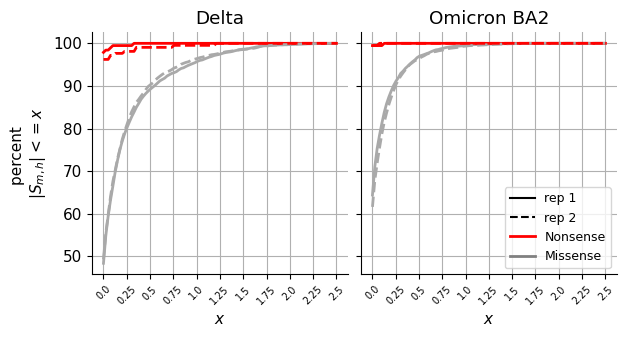

In [105]:
# BA.2
# Misense - > Nonsynonymous and nonsense -> stop
# separate the deletions

saveas = "percent_shifts_under_x_lineplot"
fig, ax = plt.subplots(1,2, figsize=[6.4,3.5], sharey='row')
tall_mut_df_chosen = tall_mut_df.query("λ_lasso == '5e-05'")

condition_col = {
    "Delta" : 0,
    "Omicron_BA2" : 1
}

replicate_line_style = {
    0 : "-",
    1 : "--"
}

sense_colors = {
    "Missense" : "darkgrey",
    "Nonsense" : "red"
}

t_points = np.linspace(0, 2.5, 100)
def perc_abs_lte(x, t):
    abs_x = np.abs(x)
    return len(abs_x[abs_x<=t]) / len(x) #)*100

for (condition, replicate, sense), df in tall_mut_df_chosen.groupby(["condition", "replicate", "sense"]):
    iter_ax = ax[condition_col[condition]]
    lt_percentages = [perc_abs_lte(df["S"], t)*100 for t in t_points]
    iter_ax.plot(
        t_points, 
        lt_percentages,
        linestyle = replicate_line_style[replicate],
        color = sense_colors[sense],
        linewidth = 2 
    )
    iter_ax.set_xticks(np.linspace(0,2.5,11),np.linspace(0,2.5,11), rotation=45, ha="center",size=7)
    sns.despine(ax=iter_ax)
    iter_ax.grid(visible=True)
    
ax[condition_col["Delta"]].set_title("Delta")
ax[condition_col["Omicron_BA2"]].set_title("Omicron BA2")

ax[0].set_ylabel("percent \n$|S_{m,h}| <= x$")
ax[0].set_xlabel("$x$")
ax[1].set_xlabel("$x$")

black_line = mlines.Line2D([], [], color='black', linestyle='-',
                          markersize=5, label='rep 1')
black_dashed = mlines.Line2D([], [], color='black',linestyle='--',
                          markersize=5, label='rep 2')
red_line = mlines.Line2D([], [], color='red', linewidth=2,linestyle='-',markersize=5, label='Nonsense')
grey_line = mlines.Line2D([], [], color='grey',linewidth=2, linestyle='-',markersize=5, label='Missense')
ax[1].legend(
    handles=[black_line, black_dashed, red_line, grey_line], 
    bbox_to_anchor = (1, 0), 
    loc='lower right', 
    frameon=True, 
    fontsize=9
)

plt.tight_layout()
fig.subplots_adjust(wspace=0.05)
fig.savefig(f"{OUTDIR}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{OUTDIR}/{saveas}.png",bbox_inches='tight')
plt.show()

## Correlation of BA2 and Delta Shifts

In [106]:
chosen_replicate_models = models.query("λ_lasso_shift == 5e-5")
mut_df_replicates = multidms.utils.combine_replicate_muts(
    {
        row.replicate:row[model_name] for idx, row in chosen_replicate_models.iterrows()
    },
    times_seen_threshold=times_seen_threshold,
    how="outer"
)
mut_df_replicates["sense"] = [
    "Nonsense" if mut == "*" else "Missense" for mut in mut_df_replicates.muts
]

In [107]:
mutdf_replicates.to_csv("../results/")

NameError: name 'mutdf_replicates' is not defined

In [ ]:
data = mut_df_replicates.dropna()
saveas="shift_corr_Delta_BA2"
fig, ax = plt.subplots(1,figsize=[4,4])
sns.scatterplot(
    data=data,
    x="avg_S_Delta",
    y="avg_S_Omicron_BA2",
#     hue = "sense",
    alpha = 0.35,
    ax=ax,
    c='0.25'
)
ax.plot()
ax.plot(
    [-1.5, 2.5], 
    [-1.5, 2.5],
    linestyle="--", 
    lw=2,
    c='royalblue'
)
corr = pearsonr(data["avg_S_Delta"], data["avg_S_Omicron_BA2"])[0]
ax.annotate(
    f"$r = {corr:.2f}$", 
    (0.05, 0.8), 
    xycoords="axes fraction", 
    fontsize=12
)
ax.set_ylabel("BA.2 Shift Value")
ax.set_xlabel("Delta Shift Value")
ax.set(xticks=np.linspace(-1.5, 2.5, 5))
ax.grid()
sns.despine(ax=ax)

fig.savefig(f"{OUTDIR}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{OUTDIR}/{saveas}.png",bbox_inches='tight')
plt.show()

Note that we're plotting the average. that's why less correlation between delta shifts makes the density of nonsense so much smaller for Delta

## Comparison to Naive approach

In [ ]:
naive_model_set = "../results/naive_approach/"
naive_models = pickle.load(open(f"{naive_model_set}/models.pkl", "rb"))
naive_models

In [ ]:
fit_dict = {f"{row.replicate}-{row.condition}":row.model_3000 for _, row in naive_models.iterrows()}
mut_df = multidms.utils.combine_replicate_muts(fit_dict,how="inner",times_seen_threshold=3)
mut_df

In [ ]:
reference = "Omicron_BA1"
for i, condition in enumerate(["Delta", "Omicron_BA2"]): 
    for replicate in [0, 1]:
        reference_betas = mut_df[f"{replicate}-{reference}_β"]
        condition_betas = mut_df[f"{replicate}-{condition}_β"]
        mut_df[f"{replicate}-{condition}_S"] = condition_betas - reference_betas
mut_df

In [ ]:
# Same X and Y Ticks

saveas = "naive_approach_replicate_shifts_correlation"

fig, ax = plt.subplots(1,2, figsize=[6.4,3.5], sharex=True, sharey=True)

for i, condition in enumerate(["Delta", "Omicron_BA2"]):
    iter_ax = ax[i]
    sns.scatterplot(
        mut_df, 
        x=f"0-{condition}_S", 
        y=f"1-{condition}_S", 
        ax=iter_ax,
        alpha=0.3,
        c='0.25'
    )
    iter_ax.set_ylim(-8, 12)
    iter_ax.set_xlim(-8, 12)
    iter_ax.plot([-8, 12], [-8, 12], "--", lw=2, c="royalblue")
    
    corr = pearsonr(mut_df[f"0-{condition}_S"], mut_df[f"1-{condition}_S"])[0]
#     sns.scatterplot(mut_df, x=f"0-{condition}_S", y=f"1-{condition}_S", ax=ax[i], alpha=0.25)
    ax[i].annotate(
        f"$r = {corr:.2f}$", 
        (0.1, 0.8), 
        xycoords="axes fraction", 
        fontsize=12
    )
    iter_ax.grid()
    sns.despine(ax=iter_ax)
    
ax[0].set_title("Delta")
ax[0].set_xlabel("replicate 1")
ax[0].set_ylabel("replicate 2")
ax[1].set_title("BA.2")
ax[1].set_xlabel("replicate 1")

plt.tight_layout()
fig.savefig(f"{OUTDIR}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{OUTDIR}/{saveas}.png",bbox_inches='tight')
plt.show()

## Betas and Shifts (Distributions and Correlations)

In [ ]:
# More space between AC and BD
# Make E shorter
# make all labels lower case
# C <-> B letters exchange
# yticks need to be aligned in C (B) to match with A
# share D xlim and ylim
# for B (c) and D, share ticks on x and y
# "indel" -> "deletions"
# Nonsense - > mut to stop
# non-synonymous mutations
# remove sliding wiondow mean from E
# should we back up the positive skew on delta. 


# data = mut_df_replicates.copy()
saveas="shift_distribution_correlation_effect"
pal = sns.color_palette('colorblind')
fig = plt.figure(figsize=[6.4, 9])

# the ratio of plot to divider between 
dist_sf = 3

# three rows of distributions
dist_rows = [[] for _ in range(3)]
for row, mut_type in enumerate(["m", "i", "n"]):
    dist_rows[row].extend([f"dist_{mut_type}_β"]*dist_sf)
    dist_rows[row].append(".")
    for param in ["S_Delta", "S_Omicron_BA2"]:
        dist_rows[row].extend([f"dist_{mut_type}_{param}"]*dist_sf)

# empty space row
number_of_rows = len(dist_rows[0])
empty_row = ["."] * len(dist_rows[0])

# correlation plot row
corr_row = ["corr_β"]*dist_sf+ ["."]
for param in ["S_Delta", "S_Omicron_BA2"]:
    corr_row.extend([f"corr_{param}"]*dist_sf)

# shift and effect plot
se_row_wc = ["se_S_Delta"]*4  + ["se_S_Omicron_BA2"]*4 + ["cbar"] + ["."]

axs = fig.subplot_mosaic(
    dist_rows+[empty_row, corr_row, empty_row, se_row_wc],
    height_ratios=[0.25, 0.25, 0.25] + [0.3, 0.8, 0.4, 1.0],
    empty_sentinel=".",
    gridspec_kw={
        "wspace": 0.05,
        "hspace": 0.05,
    }
)

query_dict = {
    "m" : "muts != '*' and muts != '-'",
    "i" : "muts == '-'",
    "n" : "muts == '*'"
}

bins_dict = {
    "β" : np.arange(-5.25, 1.0, 0.5),
    "S_Delta" : np.arange(-3.25, 3.25, 0.5),
    "S_Omicron_BA2" : np.arange(-3.25, 3.25, 0.5)
}

#################
# DISTRIBUTIONS
#################

prefix = "avg"
bins = np.arange(-5.25, 1.0, 0.5)
df = mut_df_replicates.copy()
df["avg_β"].clip(lower=-5, inplace=True)

for col, param in enumerate(["β", "S_Delta", "S_Omicron_BA2"]):
    for row, mut_type in enumerate(["m", "i", "n"]):
        
        iter_ax = axs[f"dist_{mut_type}_{param}"]
        sns.histplot(
            df.query(query_dict[mut_type]), 
            x=f"{prefix}_{param}", 
            ax=iter_ax,
            stat='probability',
            bins=bins_dict[param],
            label="Nonsense",
            color="red" if mut_type == "n" else pal.as_hex()[row],
#             color="lightgrey",
            alpha=0.5
        )
        iter_ax.set_ylim(-0.05,1.05)
        
        # remove the ylabel from all but the first column
        if col != 0: 
            iter_ax.tick_params(axis='y', labelleft=False)
        else:
            iter_ax.set_yticks(
                [0.0, 0.5], [0.0, 0.5], rotation=45, ha="right",size=9
            )
            
        if col != 0 or row != 1:
            iter_ax.set_ylabel(None)
        
        # remove the x labels from all but bottom
        if row != 2:
            iter_ax.tick_params(axis='x', labelbottom=False)
            iter_ax.set_xlabel(None)

        iter_ax.set_xlabel(None)
        
        sns.despine(ax=iter_ax)
        
# axs[].set_title("")
axs["dist_n_β"].set_xlabel(r"mut. effect in BA.1 ($\beta_m$)")
axs["dist_n_β"].xaxis.set_label_coords(0.5, -.6)


axs["dist_m_β"].text(
    0.1, 1.0, 
    f"Missense Muts", 
    ha="left", va="top", 
    size=9,
    transform=axs["dist_m_β"].transAxes
)
axs["dist_i_β"].text(
    0.1, 1.0, 
    f"Indel Muts", 
    ha="left", va="top", 
    size=9,
    transform=axs["dist_i_β"].transAxes
)
axs["dist_n_β"].text(
    0.1, 1.0, 
    f"Nonsense Muts", 
    ha="left", va="top", 
    size=9,
    transform=axs["dist_n_β"].transAxes
)

axs["dist_n_S_Delta"].set_xlabel('shift in mut. effect ($s_{m,d}$)\nrelative to BA.1')
axs["dist_n_S_Delta"].xaxis.set_label_coords(1.0, -.5)

axs["dist_m_S_Delta"].set_title("Delta")
axs["dist_m_S_Omicron_BA2"].set_title("BA.2")


#################
# CORRELATIONS
#################

data = mut_df_replicates.dropna().copy()
data['0_β'].clip(lower=-5, inplace=True)
data['1_β'].clip(lower=-5, inplace=True)
# plot the correlations of parameters
for col, param in enumerate(["β", "S_Delta", "S_Omicron_BA2"]):
    iter_ax = axs[f"corr_{param}"]
    x, y = data[f"0_{param}"], data[f"1_{param}"]
    sns.scatterplot(
        data = data,
        x = f"0_{param}",
        y = f"1_{param}",
        ax=iter_ax,
        s=80, 
        alpha=0.3,     
        c='0.25'
    )
    
    # remove y labels from all but first column
    if col != 0: 
        iter_ax.tick_params(axis='y', labelleft=False)
        iter_ax.set_ylabel(None)
    else:
        iter_ax.set_ylabel("replicate 2")
    iter_ax.set_xlabel("replicate 1")
    
    # set limits
    xl, xh = x.min()-0.5, x.max()+0.5
    yl, yh = y.min()-0.5, y.max()+0.5
    iter_ax.set_xlim(xl, xh)
    iter_ax.set_ylim(yl, yh)
    
    # line of equivilence
    iter_ax.plot(
        [xl, xh], 
        [yl, yh],
        linestyle="--", 
        lw=2,
        c='royalblue'
    )
    
    corr = pearsonr(x, y)[0]
    iter_ax.annotate(
        f"$r = {corr:.2f}$", 
        (0.1, 0.9), 
        xycoords="axes fraction", 
        fontsize=11
    )
    sns.despine(ax=iter_ax)


#################
# SHIFT & EFFECT
#################   


# Define variables to plot
mut_effect_var = 'avg_β'
lower_clip = -5
shift_delta_var = "avg_S_Delta"
shift_ba2_var = "avg_S_Omicron_BA2"


# Get data and clip betas
# data = mut_df.copy()
data = mut_df_replicates.dropna().copy()

# print('Subsetting to mutations with multidms data')
# data = data[data['β'].notnull()]
data[mut_effect_var].clip(lower=lower_clip, upper=1, inplace=True)
data[shift_delta_var].clip(lower=-2.5, upper=3.1, inplace=True)
data[shift_ba2_var].clip(lower=-2.5, upper=3.1, inplace=True)

# Compute a statistic of shifts as a function of betas
stat_dict = {
    key : []
    for key in [mut_effect_var, 'metric_BA2', 'metric_Delta']
}
half_window_size = 0.25
for beta in np.arange(lower_clip, 0.5, 0.1):
    data_i = data[data[mut_effect_var].between(beta-half_window_size, beta+half_window_size)]
    if len(data_i) < 20:
        continue
    stat_dict[mut_effect_var].append(beta)
    stat_dict['metric_Delta'].append(data_i[shift_delta_var].median())
    stat_dict['metric_BA2'].append(data_i[shift_ba2_var].median())
    
stat_df = pd.DataFrame(stat_dict)


# Plot 2D histograms
bin_size = 0.15
min_beta = data[mut_effect_var].min()
max_beta = data[mut_effect_var].max()
beta_bins = np.arange(min_beta, max_beta+bin_size, bin_size)
min_shift = data[[shift_delta_var, shift_ba2_var]].min().min()
max_shift = data[[shift_delta_var, shift_ba2_var]].max().max()
shift_bins = np.arange(min_shift, max_shift+bin_size, bin_size)
vmax = 30
print(f'histogram vmax: {vmax}')

# Delta Heatmap
iter_ax = axs["se_S_Delta"]
sns.histplot(
    x=mut_effect_var, y=shift_delta_var, data=data,
    bins=[beta_bins, shift_bins], vmax=vmax, ax=iter_ax,
    color='k', cbar=False
)
sns.lineplot(
    x=mut_effect_var, y='metric_Delta', data=stat_df,
    ax=iter_ax, color='firebrick'
)
iter_ax.plot([-3.0,1.0], [3.0,-1.0], ls='--', c='0.25')
iter_ax.grid()
iter_ax.set(
    xlabel='mut. effect in BA.1',
    xticks=[-5, -2.5, 0],
    title="Delta",
    ylabel="Shift"
)
sns.despine(ax=iter_ax)



# BA.1 heatmap
iter_ax = axs["se_S_Omicron_BA2"]
sns.histplot(
    x=mut_effect_var, y=shift_ba2_var, data=data,
    bins=[beta_bins, shift_bins], vmax=vmax, ax=iter_ax,
    color='k', cbar=False #, cbar_ax=axs["cbar"],

)
sns.lineplot(
    x=mut_effect_var, y='metric_BA2', data=stat_df,
    ax=iter_ax, color='firebrick'
)
iter_ax.plot([-3.0,1.0], [3.0,-1.0], ls='--', c='0.25')
iter_ax.grid()
iter_ax.set(
    xlabel='mut. effect in BA.1',
    xticks=[-5, -2.5, 0],
    title="BA.2"
)
iter_ax.tick_params(axis="y", labelleft=False)
iter_ax.set_ylabel(None)
sns.despine(ax=iter_ax)


# make custom colorbar
axs["cbar"].set_axis_off()
import matplotlib as mpl
cmap = mpl.colormaps['gist_yarg']
norm = mpl.colors.Normalize(vmin=0, vmax=30)
cb1 = plt.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax = axs["cbar"], 
    orientation='vertical',
    fraction=0.5,
    label="counts"
)      


# Add subpanel labels
axs["dist_m_β"].text(
    -0.1, 1.00, 
    f"A", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["dist_m_β"].transAxes
)

axs["corr_β"].text(
    -0.1, 1.00, 
    f"B", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["corr_β"].transAxes
)

axs["dist_m_S_Delta"].text(
    -0.1, 1.00, 
    f"C", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["dist_m_S_Delta"].transAxes
)

axs["corr_S_Delta"].text(
    -0.1, 1.00, 
    f"D", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["corr_S_Delta"].transAxes
)

axs["se_S_Delta"].text(
    -0.1, 1.10, 
    f"E", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["se_S_Delta"].transAxes
)

fig.savefig(f"{OUTDIR}/{saveas}.png", bbox_inches='tight')
fig.savefig(f"{OUTDIR}/{saveas}.pdf", bbox_inches='tight')

plt.show()    


In [ ]:
mut_df_replicates.query(
    "muts == '-'"
).sort_values(
    by="avg_S_Omicron_BA2"
)[["wts","sites", "muts", "avg_S_Omicron_BA2"]].head(10)

## Shifted Mutations, Heat and Sitemap

In [108]:
# could add a 'min' column of 0, and 1
chosen_replicate_models = models.query("λ_lasso_shift == 5e-5")
mut_df_replicates = multidms.utils.combine_replicate_muts(
    {
        row.replicate:row[model_name] for idx, row in chosen_replicate_models.iterrows()
    },
    times_seen_threshold=times_seen_threshold,
    how="inner"
)
mut_df_replicates["sense"] = ["Nonsense" if mut == "*" else "Missense" for mut in mut_df_replicates.muts]
rename_omicron = {
    c:"_".join(c.split("_")[:2]+[c.split("_")[3]])
    for c in mut_df_replicates.columns if "Omicron" in c
}
mut_df_replicates.rename(rename_omicron, axis=1, inplace=True)
site_map = model.data.site_map
mut_df_replicates = (
    mut_df_replicates
    .merge(
        site_map,
        left_on="sites",
        right_index=True,
        how="left"
    )
#     .drop("wts", axis=1)
    .rename(
        {
            "Omicron_BA1": "BA1_wt",
            "Delta": "Delta_wt",
            "Omicron_BA2" : "BA2_wt"
        },
        axis=1
    )
)
mut_df_replicates = mut_df_replicates.assign(
#     is_BA1_wt = [
#         True if aad == aar else False
#         for aad, aar in zip(mut_df_replicates.BA1_wt,mut_df_replicates.BA1_wt)
#     ],
    is_Delta_wt = [
        True if aad == aar else False
        for aad, aar in zip(mut_df_replicates.Delta_wt,mut_df_replicates.BA1_wt)
    ],
    is_BA2_wt = [
        True if aad == aar else False
        for aad, aar in zip(mut_df_replicates.BA2_wt,mut_df_replicates.BA1_wt)
    
    ]
)
mut_df_replicates.head()

,wts,sites,muts,0_β,1_β,avg_β,0_S_Delta,1_S_Delta,avg_S_Delta,0_S_BA2,1_S_BA2,avg_S_BA2,sense,Delta_wt,BA1_wt,BA2_wt,is_Delta_wt,is_BA2_wt
mutation,,,,,,,,,,,,,,,,,,
M1I,M,1,I,-2.975049,-3.927958,-3.451503,0.0,0.000000,0.000000,0.000000,0.0,0.000000,Missense,M,M,M,True,True
F2L,F,2,L,0.186080,0.210534,0.198307,-0.0,-0.000000,0.000000,-0.201996,0.0,-0.100998,Missense,F,F,F,True,True
F2S,F,2,S,0.188163,-0.071015,0.058574,-0.0,0.000000,0.000000,0.000000,-0.0,0.000000,Missense,F,F,F,True,True
F2V,F,2,V,0.219565,-0.059422,0.080071,-0.0,-0.002961,-0.001481,0.000000,0.0,0.000000,Missense,F,F,F,True,True
V3A,V,3,A,-0.016013,-0.042291,-0.029152,-0.0,-0.000000,0.000000,-0.000000,-0.0,0.000000,Missense,V,V,V,True,True


In [109]:
same_fx = lambda x: x[0] if np.all(x == x[0]) else -1
cols_to_collapse = [col for col in mut_df_replicates.columns if "avg_" in col]
cols_to_collapse.extend(['sites', 'sense', 'BA1_wt', 'BA2_wt', 'Delta_wt', 'is_BA2_wt', 'is_Delta_wt'])
shifts_by_site = mut_df_replicates[cols_to_collapse].groupby("sites").agg(
    max_abs_S_BA2 = ('avg_S_BA2', lambda x: np.max(np.abs(x))),
    max_abs_S_Delta = ('avg_S_Delta', lambda x: np.max(np.abs(x))),
    
    mean_S_BA2 = ('avg_S_BA2', np.mean),
    mean_S_Delta = ('avg_S_Delta', np.mean),
    
    sum_S_BA2 = ('avg_S_BA2',  np.sum),
    sum_S_Delta = ('avg_S_Delta', np.sum),

#     is_BA1_wt=('is_BA1_wt', same_fx),
    BA2_wt=('BA2_wt', same_fx),
    Delta_wt=('Delta_wt', same_fx),
    is_BA2_wt=('is_BA2_wt', same_fx),
    is_Delta_wt=('is_Delta_wt', same_fx)
)
assert -1 not in shifts_by_site.Delta_wt
# assert -1 not in shifts_by_site.BA1_wt
assert -1 not in shifts_by_site.BA2_wt
shifts_by_site

,max_abs_S_BA2,max_abs_S_Delta,mean_S_BA2,mean_S_Delta,sum_S_BA2,sum_S_Delta,BA2_wt,Delta_wt,is_BA2_wt,is_Delta_wt
sites,,,,,,,,,,
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,M,M,True,True
2,0.100998,0.001481,-0.033666,-0.000494,-0.100998,-0.001481,F,F,True,True
3,0.110398,0.079056,0.032543,0.013176,0.195255,0.079056,V,V,True,True
4,0.060683,0.125552,-0.024123,-0.036539,-0.072370,-0.109617,F,F,True,True
5,0.655798,0.280303,0.041203,-0.081128,0.700453,-1.379179,L,L,True,True
...,...,...,...,...,...,...,...,...,...,...
1248,0.043238,0.165269,-0.001671,0.046353,-0.010029,0.278118,C,C,True,True
1249,0.035850,0.058838,0.005904,-0.013723,0.035422,-0.082339,S,S,True,True
1250,0.062389,0.124266,-0.008907,0.033581,-0.053441,0.201488,C,C,True,True


In [110]:
shifts_by_site.index.dtype

dtype('int64')

In [111]:
site_map.reset_index().rename({"index":"site"})

,index,Delta,Omicron_BA1,Omicron_BA2
0,1,M,M,M
1,2,F,F,F
2,3,V,V,V
3,4,F,F,F
4,5,L,L,L
...,...,...,...,...
1235,1248,C,C,C
1236,1249,S,S,S
1237,1250,C,C,C
1238,1251,G,G,G


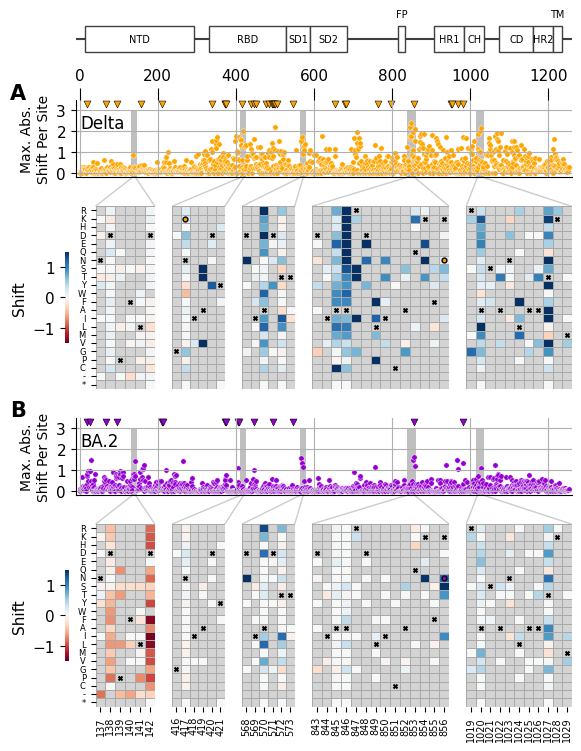

In [112]:
# xlabel = sites
# captilaization
# add sites to the second heatmap
# indicate indels along with N.I.S (check to make sure you're capturing all nis)
# make interactive heatmap and send link to where folks can find that.

saveas = "shift_by_site_heatmap_zoom"

site_ranges = {
    "zoom1" : [137, 142],
    "zoom2" : [416, 421],
    "zoom3" : [568, 573],
    "zoom4" : [843, 856],
    "zoom5" : [1019, 1029]
}

# heatmap ax width ratios
width_ratios = [(end-start) for key, (start, end) in site_ranges.items()]

# make the first one a little bigger for the color bar
width_ratios[0] += width_ratios[0] * 0.5


# Plot domain architecture in primary sequence
# based on structure papers (Gobeil et al., 2022, Molecular Cell)
# (Duan et al., 2020, Frotiers in Immunology)
domain_dict = {
    'NTD' : [13, 293],
    'RBD' : [330, 528],
    'SD1' : [528, 590],
    'SD2' : [590, 685],
    'FP' : [815, 834],
    'HR1' : [907, 985],
    'CH' : [985, 1035],
    'CD' : [1075, 1162],
    'HR2' : [1162, 1211],
    'TM' : [1211, 1234],
}

sort_order = [
    "R","K","H","D","E","Q","N","S",
    "T","Y","W","F","A","I","L","M",
    "V","G","P","C","-","*",
]

fig = plt.figure( figsize=[6.4, 9])
axs = fig.subplot_mosaic(
    [
        ["Annotation"]*5,
        ["Delta"]*5,
        [f"{k}_Delta" for k in list(site_ranges.keys())],
        [f"{k}_Delta" for k in list(site_ranges.keys())], 
        ["BA2"]*5,
        [f"{k}_BA2" for k in list(site_ranges.keys())],
        [f"{k}_BA2" for k in list(site_ranges.keys())]
    ],
    
    height_ratios=[
        1.5, 
        2, 
        2, 
        2,
        2,
        2, 
        2
    ],
    empty_sentinel=".",
    # set the width ratios between the columns
    width_ratios=width_ratios,
    gridspec_kw={
        "wspace": 0.20,
        "hspace": 0.4,
    }
)

# derived from
# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/axes_zoom_effect.html
def connect_bbox(bbox1, bbox2,
                 loc1a, loc2a, loc1b, loc2b,
                 prop_lines, prop_patches=None):
    if prop_patches is None:
        prop_patches = {
            **prop_lines,
            "alpha": prop_lines.get("alpha", 1) * 0.2,
            "clip_on": False,
        }

    c1 = BboxConnector(
        bbox1, bbox2, loc1=loc1a, loc2=loc2a, clip_on=False, **prop_lines)
    c2 = BboxConnector(
        bbox1, bbox2, loc1=loc1b, loc2=loc2b, clip_on=False, **prop_lines)

    bbox_patch1 = BboxPatch(bbox1, **prop_patches)
    bbox_patch2 = BboxPatch(bbox2, **prop_patches)

    p = BboxConnectorPatch(bbox1, bbox2,
                           loc1a=loc1a, loc2a=loc2a, loc1b=loc1b, loc2b=loc2b,
                           clip_on=False,
                           **prop_patches)

    return c1, c2, bbox_patch1, bbox_patch2, p

def zoom_effect03(ax1, ax2, xmin, xmax, **kwargs):

    mybbox1 = ax1.bbox
    
    bbox = Bbox.from_extents(xmin, 0, xmax, 1)
    mybbox2 = TransformedBbox(bbox, ax2.get_xaxis_transform())

    prop_patches = {**kwargs, "ec": "none", "alpha": 0.2}

    c1, c2, bbox_patch1, bbox_patch2, p = connect_bbox(
        mybbox1, mybbox2,
        loc1a=2, loc2a=3, loc1b=1, loc2b=4,
        prop_lines=kwargs, prop_patches=prop_patches)

    ax2.add_patch(c1)
    ax2.add_patch(c2)
    ax2.add_patch(p)

    return c1, c2, bbox_patch1, bbox_patch2, p

#############
# sitewise
#############


pal = sns.color_palette('colorblind')
cs = ['darkviolet', 'orange']
cs = {
    'BA2' : 'darkviolet', 
    'Delta' : 'orange'
}


# Plot per-site metric
metric_prefix = 'max_abs_S_' # 'delta_bind_S_' # 
# metric_prefix = 'sum_S_' # 'delta_bind_S_' # 
for (i, homolog) in enumerate(['BA2', 'Delta']):
    
    sns.scatterplot(
        x='sites', 
        y=f'{metric_prefix}{homolog}',
        data=shifts_by_site, 
        s=15,
        ax=axs[homolog], 
        color=cs[homolog],
        label=""
    )
    nis = shifts_by_site.query(f"not is_{homolog}_wt")
    sns.scatterplot(
        x='sites', 
        y=np.repeat(3.3, len(nis)),
        data=nis, 
        s=25,
        ax=axs[homolog],
        marker='v',
        facecolor=cs[homolog], 
        edgecolor="black"
    )

    
    
    axs[homolog].set_ylabel("max($|S_{m \in site}|$)", size=10)
    axs[homolog].grid()
    axs[homolog].set(
        xlim=[-10,1260],
        yticks=[0,1,2,3],
#         ylabel=homolog,/
    )
    sns.despine(ax=axs[homolog])
    
    axs[homolog].tick_params(
        axis='x', 
        bottom=False,
        labelbottom=False,
        labeltop=True if homolog == "Delta" else False,
        top=True if homolog == "Delta" else False,
        size=9
    )
    axs[homolog].set_xlabel(None)
#     axs[homolog].set_ylabel("max($|S_{m \in site}|$)", size=10)
    axs[homolog].set_ylabel("Max. Abs.\nShift Per Site", size=10)


axs["BA2"]._shared_axes['x'].join(axs["BA2"], axs["Delta"])

plot_rectangles = True
for zoom, site_range in site_ranges.items():
    if not plot_rectangles:
        continue
    (site_i, site_j) = site_range
    for (i, homolog) in enumerate(['BA2', 'Delta']):
        rect = patches.Rectangle(
            (site_i-5, -0.2), site_j-site_i+11, 3.2,
            edgecolor='none', facecolor='0.75', zorder=0
        )
        axs[homolog].add_patch(rect)
        
        
#############
# Annotation
#############

for (domain, (start, end)) in domain_dict.items():
    rectangle = patches.Rectangle((start, 1), end-start, 2, edgecolor='0.25', facecolor='white')
    axs["Annotation"].add_patch(rectangle)
    rx, ry = rectangle.get_xy()
    cx = rx + rectangle.get_width()/2.0
    cy = ry - 0.05 + rectangle.get_height()/2.0
    if domain in ['FP', 'TM']:
        cy += 2
    axs["Annotation"].annotate(
        domain, (cx, cy), color='black', ha='center', va='center',
        fontsize=7
    )

axs["Annotation"].set(ylim=[-0.5,4], yticks=[])
sns.despine(left=True, bottom=True, ax=axs["Annotation"])

axs["Annotation"].sharex(axs["BA2"])
axs["Annotation"].axhline(2, c='0.25', zorder=0)
axs["Annotation"].xaxis.set_tick_params(which='both', bottom=False, labelbottom=False, labeltop=False)

#############
# Heatmap
#############

for (i, homolog) in enumerate(['Delta', 'BA2']):
    
    df_shifts_wide = mut_df_replicates.pivot(
        index='muts', 
        columns='sites', 
        values=f'avg_S_{homolog}'
    ).loc[sort_order, :]

    for zoom, (start, end) in site_ranges.items():
        
        iter_ax = axs[f"{zoom}_{homolog}"]
        iter_ax.set_facecolor("lightgrey")
        sites = [s for s in list(range(start, end+1)) if s in df_shifts_wide.columns]
        
        sns.heatmap(
            df_shifts_wide.loc[:, sites], 
            cbar=True if zoom == "zoom1" else False,
            cbar_kws={
                "shrink": 0.5, 
                "location":'left',
                'anchor': (-1.5, 0.5),
                'label' : 'Shift'
            },
            ax = iter_ax,
            linewidth=.5, 
            linecolor="darkgrey",
            center=0,
            cmap='RdBu',
            vmin=-1.5,
            vmax=1.5,
            xticklabels=False,
            yticklabels=False,
        )

        for i, site in enumerate(sites):
            for j, mut in enumerate(sort_order):
                
                is_ref_wt = True if mut == site_map.loc[site,"Omicron_BA1"] else False
                if is_ref_wt:
                    iter_ax.scatter(
                        [i+0.5], 
                        [j+0.5], 
                        marker="x", 
                        s=8, 
                        c="black"
                    )
                hom = homolog if homolog == "Delta" else "Omicron_BA2"
                is_nis = (
                    True 
                    if mut ==  site_map.loc[site,hom] and
                    mut !=  site_map.loc[site,"Omicron_BA1"]
                    else False
                )
                
                if is_nis:
                    iter_ax.scatter(
                        [i+0.5], 
                        [j+0.5], 
                        marker="o", 
                        s=12, 
                        facecolors=cs[homolog],
                        edgecolors="black"
                    )

        if zoom != "zoom1":
            axs[f"{zoom}_{homolog}"].tick_params(axis='y', left=False, labelleft=False)
            sns.despine(left=True, bottom=True, ax=axs[f"{zoom}_{homolog}"])  
        else:
            axs[f"{zoom}_{homolog}"].set_yticks(
                [s+0.5 for s in range(len(sort_order))],
                labels=sort_order, 
                va="center",
                size=6
            )
            
        axs[f"{zoom}_{homolog}"].set_ylabel(None)
            
        if homolog == "Delta":
            axs[f"{zoom}_{homolog}"].tick_params(axis='x', bottom=False, labelbottom=False) 
        else:
            axs[f"{zoom}_{homolog}"].sharex(axs[f"{zoom}_Delta"])
        axs[f"{zoom}_{homolog}"].set_xticks(
            [s+0.5 for s in range(len(sites))],
             labels=sites, 
             ha="center",
            rotation=90,
            size=7
        )
        axs[f"{zoom}_{homolog}"].set_xlabel(None)

for zoom, (start, end) in site_ranges.items():
    for homolog in ['Delta', 'BA2']:
        zoom_effect03(axs[f"{zoom}_{homolog}"], axs[homolog], start, end, alpha= 0.2)


axs["Delta"].text(
    -0.1, 1.10, 
    f"A", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["Delta"].transAxes
)
axs["Delta"].text(
    0.01, .82, 
    f"Delta", 
    ha="left", va="top", 
    size=12,
    transform=axs["Delta"].transAxes
)

axs["BA2"].text(
    -0.1, 1.10, 
    f"B", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["BA2"].transAxes
)
axs["BA2"].text(
    0.01, .82, 
    f"BA.2", 
    ha="left", va="top", 
    size=12,
    transform=axs["BA2"].transAxes
)

fig.savefig(f"{OUTDIR}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{OUTDIR}/{saveas}.png",bbox_inches='tight')
plt.show()

## Sitewise Sum of Shifts by Site

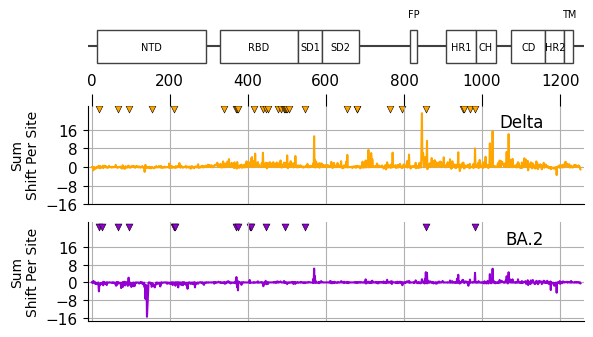

In [113]:
# xlabel

saveas = "sum_shift_by_site"

# Plot domain architecture in primary sequence
# based on structure papers (Gobeil et al., 2022, Molecular Cell)
# (Duan et al., 2020, Frotiers in Immunology)
domain_dict = {
    'NTD' : [13, 293],
    'RBD' : [330, 528],
    'SD1' : [528, 590],
    'SD2' : [590, 685],
    'FP' : [815, 834],
    'HR1' : [907, 985],
    'CH' : [985, 1035],
    'CD' : [1075, 1162],
    'HR2' : [1162, 1211],
    'TM' : [1211, 1234],
}

fig = plt.figure(figsize=[6.4, 4])
axs = fig.subplot_mosaic(
    [
        ["Annotation"],
        ["Delta"],
        ["BA2"]
    ],
    
    height_ratios=[
        1.5, 
        2, 
        2,
    ],
    empty_sentinel=".",
    gridspec_kw={
        "wspace": 0.20,
        "hspace": 0.2,
    }
)


#############
# sitewise
#############

pal = sns.color_palette('colorblind')
cs = ['darkviolet', 'orange']
cs = {
    'BA2' : 'darkviolet', 
    'Delta' : 'orange'
}

# Plot per-site metric
# metric_prefix = 'max_abs_S_' # 'delta_bind_S_' # 
metric_prefix = 'sum_S_' # 'delta_bind_S_' # 
for (i, homolog) in enumerate(['BA2', 'Delta']):
    
    sns.lineplot(
        x='sites', 
        y=f'{metric_prefix}{homolog}',
        data=shifts_by_site,
        ax=axs[homolog], 
        color=cs[homolog],
        label=""
    )
    nis = shifts_by_site.query(f"not is_{homolog}_wt")
    sns.scatterplot(
        x='sites', 
        y=np.repeat(25, len(nis)),
        data=nis, 
        s=25,
        ax=axs[homolog],
        marker='v',
        facecolor=cs[homolog], 
        edgecolor="black"
    )

    axs[homolog].grid()
    axs[homolog].set(
        xlim=[-10,1260],
        yticks=np.linspace(-16, 16, 5)
    )
    sns.despine(ax=axs[homolog])
    
    axs[homolog].tick_params(
        axis='x', 
        labelbottom=False,
        bottom=False,
        labeltop=True if homolog == "Delta" else False,
        top=True if homolog == "Delta" else False,
        size=9
    )
    axs[homolog].set_xlabel(None)
    axs[homolog].set_ylabel("Sum\nShift Per Site", size=10)
    
axs["BA2"]._shared_axes['x'].join(axs["BA2"], axs["Delta"])
        
#############
# Annotation
#############

for (domain, (start, end)) in domain_dict.items():
    rectangle = patches.Rectangle((start, 1), end-start, 2, edgecolor='0.25', facecolor='white')
    axs["Annotation"].add_patch(rectangle)
    rx, ry = rectangle.get_xy()
    cx = rx + rectangle.get_width()/2.0
    cy = ry - 0.05 + rectangle.get_height()/2.0
    if domain in ['FP', 'TM']:
        cy += 2
    axs["Annotation"].annotate(
        domain, (cx, cy), color='black', ha='center', va='center',
        fontsize=7
    )

axs["Annotation"].set(ylim=[-0.5,4], yticks=[])
sns.despine(left=True, bottom=True, ax=axs["Annotation"])

axs["Annotation"].sharex(axs["BA2"])
axs["Annotation"].axhline(2, c='0.25', zorder=0)
axs["Annotation"].xaxis.set_tick_params(which='both', bottom=False, labelbottom=False, labeltop=False)

axs["Delta"].text(
    .92, .92, 
    f"Delta", 
    ha="right", va="top", 
    size=12,
    transform=axs["Delta"].transAxes
)

axs["BA2"].text(
    .92, .92, 
    f"BA.2", 
    ha="right", va="top", 
    size=12,
    transform=axs["BA2"].transAxes
)

fig.savefig(f"{OUTDIR}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{OUTDIR}/{saveas}.png",bbox_inches='tight')
plt.show()

## Validation Mutations Shift V Titer fold change

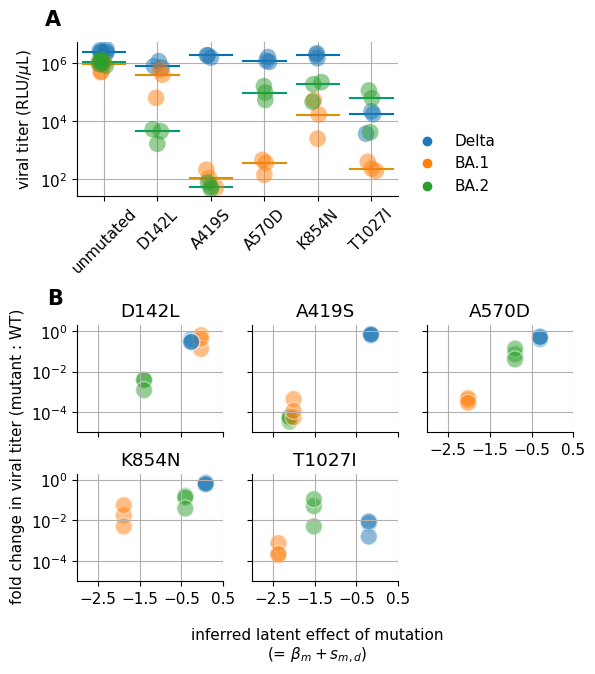

In [114]:
# WT -> unmutated
# shift the xlabel up a bit
# change panel B tick labels to be whole numbers 0, -1, -2

saveas="validation_titer_fold_change"

row1 = ['titer', 'titer', '.']
row2 = ['D142L', 'A419S', 'A570D'] 
row3 = ['K854N', 'T1027I', 'legend']
empty_row = ["."] * 3

fig = plt.figure( figsize=[6.4, 7])
axs = fig.subplot_mosaic(
    [row1, empty_row, row2, row3],
    height_ratios=[
        1, 0.3, 0.7, 0.7
    ],
    empty_sentinel=".",
    # set the width ratios between the columns
#     width_ratios=width_ratios,
    gridspec_kw={
        "wspace": 0.20,
        "hspace": 0.4,
    }
)


#############
# TITERS
#############

# Read in data
titers_df = pd.read_csv('../data/viral_titers.csv')
titers_df.rename(
    columns={'RLUperuL':'titer', 'background':'homolog'},
    inplace=True
)

# Add a column giving the replicate and mutation
titers_df['replicate'] = titers_df['virus'].apply(lambda x: x[-1])
titers_df['mutation'] = titers_df['virus'].str.extract(r'_(\S+)_')
titers_df['mutation'].fillna('unmutated', inplace=True)
titers_df['mutation'].replace('142L', 'D142L', inplace=True)

# Plot data for a given mutation
validation_mutations = ['D142L', 'A419S', 'A570D', 'K854N', 'T1027I']
#mutation = 'A570D'
homologs = ['Delta', 'BA.1', 'BA.2']
replicates = ['1', '2', '3']
# plt.figure(figsize=[7,4])
xticklabels = ['unmutated'] + validation_mutations
pal = sns.color_palette('colorblind')
hex_codes = pal.as_hex()
for (i, homolog) in enumerate(homologs):
    
    data = titers_df[(titers_df['homolog'] == homolog)]
    
    sns.stripplot(
        x='mutation', y='titer', data=data, ax=axs['titer'],
        order=xticklabels, s=12, alpha=0.5,
        hue='homolog', hue_order=['Delta', 'BA.1', 'BA.2'],
    )
    sns.boxplot(
        x='mutation', y='titer', data=data, ax=axs['titer'],
        order=xticklabels,
        showfliers=False, showbox=False, showcaps=False,
        medianprops=dict(color=hex_codes[i]),
        whiskerprops={'visible': False},
    )

handles, labels = axs['titer'].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
axs['titer'].legend(by_label.values(), by_label.keys(), bbox_to_anchor=[1,0.5])

axs['titer'].set_yscale('log')
axs['titer'].set_yticks([1e2, 1e4, 1e6])
axs['titer'].set_xticklabels(axs['titer'].get_xticklabels(), rotation = 45)
axs['titer'].set_ylabel(r'viral titer (RLU/$\mu$L)')
axs['titer'].set_xlabel('')
axs['titer'].grid()
sns.despine(ax = axs['titer'])


#############
# FOLD CHANGE
#############

replicate_models = models.query("λ_lasso_shift == 5e-5")
fit_dict = {row.replicate:row[model_name] for _, row in replicate_models.iterrows()}
mut_df = multidms.utils.combine_replicate_muts(fit_dict, times_seen_threshold=3, how="inner")

rep0 = fit_dict[0]
for homolog in rep0.data.conditions:
    if homolog == rep0.data.reference:

        mut_df[f"β_{homolog}"] = mut_df.avg_β
    else:

        mut_df[f"β_{homolog}"] = mut_df.avg_β + mut_df[f"avg_S_{homolog}"]

mut_df.reset_index(inplace=True)

# Read in data
val_df = pd.read_csv('../data/spike_validation_data.csv')

# Restructure the data
val_dict = {
    key : []
    for key in [
        'mutation', 'fold_change', 'homolog', 'replicate',
        'predicted_beta'
    ]
}
validation_mutations = ['D142L', 'A419S', 'A570D', 'K854N', 'T1027I']
for i, row in val_df.iterrows():
    for mutation in validation_mutations:
        homolog = row['background'].replace('.', '')
        homolog = "Omicron_" + homolog if "BA" in homolog else homolog

        val_dict['mutation'].append(mutation)
        val_dict['fold_change'].append(row[mutation])
        val_dict['homolog'].append(homolog)
        val_dict['replicate'].append(row['replicate'])

        predicted_beta = float(mut_df[
            mut_df['mutation'] == mutation
        ][f'β_{homolog}'].values[0])
        val_dict['predicted_beta'].append(predicted_beta)

val_df = pd.DataFrame(val_dict)
val_df['site'] = val_df['mutation'].apply(lambda x: int(x[1:-1]))
val_df['homolog'].replace('Omicron_BA1', 'BA.1', inplace=True)
val_df['homolog'].replace('Omicron_BA2', 'BA.2', inplace=True)
val_df.sort_values('site', inplace=True)

for (i, mutation) in enumerate(validation_mutations):
    data = val_df[val_df['mutation'] == mutation]
    iter_ax = axs[mutation]
    sns.scatterplot(
        x='predicted_beta', y='fold_change', data=data,
        hue='homolog', ax=iter_ax, s=150, alpha=0.5,
        hue_order=['Delta', 'BA.1', 'BA.2']
    )
    iter_ax.set(
        title=mutation, xlabel='', ylabel='',
        yscale='log', ylim=[1e-5,2], yticks=[1, 1e-2, 1e-4],
        xlim=[-3, 0], xticks=np.linspace(-2.5, 0.5, 4)
    )
    iter_ax.grid()
    iter_ax.get_legend().remove()
    sns.despine(ax=iter_ax)
    
    if mutation in ['D142L', 'A419S']:
        iter_ax.tick_params(axis="x", labelbottom=False)
    
    if mutation not in ['D142L', 'K854N']:
        iter_ax.tick_params(axis="y", labelleft=False)

fig.text(
    0.5, 0.0, 'inferred latent effect of mutation\n(= $β_m + s_{m,d}$)',
    ha='center'
)
fig.text(
    0.02, 0.29, 'fold change in viral titer (mutant : WT)',
    va='center', rotation='vertical'
)
axs["legend"].set_axis_off()

axs["titer"].text(
    -0.05, 1.15, 
    f"A", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["titer"].transAxes
)
axs["D142L"].text(
    -0.1, 1.25, 
    f"B", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["D142L"].transAxes
)

fig.savefig(f"{OUTDIR}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{OUTDIR}/{saveas}.png",bbox_inches='tight')
plt.show()